# INFORMACIÓN DEL PROYECTO

Tratamos de averiguar qué variables inciden en si un préstamo va a ser impagado


### HIPÓTESIS

La hipótesis de la que partimos es que existen variables que permiten explicar la probabilidad de que un préstamo resulte impagado. 

En concreto partimos de datasets cuyo origen está en el reconocido "All Lending Club loan data" que recopila información sobre diversas variables de préstamos de USA. En Kaggle existe información hasta 2018 (https://www.kaggle.com/datasets/wordsforthewise/lending-club). Para obtener información más actualizada, habría que ser miembro del Club y obtenerla directamente (https://www.lendingclub.com/). Sin emabrgo, dada la longitud y tamaño de la base de datos (más de 1 GB) usaremos un dataset más reducido con datos de 2012 y que usan, a modo de ejemplo, para el servicio SageMaker de Amazon Web Services (AWS).

Los datos se componen de 2 dataset en formato csv con las siguientes columnas.

Dataset 1:

* id: número de identificación del préstamo
* loan_status: estado actual del préstamo (normalmente 3 estados: fully paid, charged off, current)
* loan_amount: importe concedido del préstamo
* funded_amount_by_investors: monto recibido efectivamente por el prestatario (deducidas las comisiones de apertura)
* loan_term: número de pagos del préstamo en meses (36 o 60)
* interest_rate: tipo de interés del préstamo
* installment: cuota mensual del préstamo
* grade: grado clasificación dado por LC (Lending Club)
* subgrade: subgrado otorgado por LC
* verification_status: indica si los ingresos del prestatario han sido verificados por LC
* issued_on: fecha de emisión del préstamo
* purpose: propósito del préstamo (coche, negocio, tarjeta, etc)
* dti: ratio que divide el pago total de cuotas en préstamos del prestatario sobre el total de ingresos mensuales, excluyendo el pago de la hipoteca.
* inquiries_last_six_months: númeo de consultas del prestatario en los últimos 6 meses
* open_credit_lines: número de préstamos del prestatario abiertas.
* derogatory_public_records: número de registros públicos negativos
* revolving_line_utilization_rate: tasa de uso de crédito en tarjetas revolving
* total_credit_lines: total de créditos del pretatario en la base de datos

Dataset 2:

* id: número de identificación del préstamo
* employment_length: tiempo que el prestario ha estado trabajando en años (entre 0 y 10, si es más se le asigna 10)
* employer_title: nombre del empleo del prestatario
* home_ownership: (own= vivienda en propiedad, rent: alquilada)
* annual_income: ingresos anuales del prestatario

Ambos dataset tienen 39717 filas de datos

#### Hipótesis de nuestro proyecto

En nuestro poyecto nos centraremos en averiguar si puede predecirse el pago o impago de un préstamo a partir de las variables mencionadas en el dataset.


## OBTENCIÓN DE LOS DATOS

### DATASETS Y FUENTES ALTERNATIVAS DE DATOS

Los datos están disponibles en la web del servicio de Amazon SageMaker de AWS como ejemplo para la demostración de sus servicios.

En concreto las url de cada dataset son las siguientes:

[Dataset 1](https://static.us-east-1.prod.workshops.aws/public/794937ea-b720-4c4b-821c-6535c6b64079/static/datasets/loans-part-1.csv)

[Dataset 2](https://static.us-east-1.prod.workshops.aws/public/794937ea-b720-4c4b-821c-6535c6b64079/static/datasets/loans-part-2.csv)

Empezamos importando las librerías que vamos a necesitar

In [203]:
# Importamos las librerías Python que vamos a necesitar en nuestro estudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC


import pickle

import sys
sys.path.append('../')
from utils.eda_functions import *

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')


Empezamos viendo el contenido de cada uno de los dataset (columnas, tipo de datos en cada columna, posible existencia de valores nulos o el número de filas de cada dataset)

In [204]:
df_1 = pd.read_csv('../data/raw/loans-part-1.csv')
df_2 = pd.read_csv('../data/raw/loans-part-2.csv')

In [205]:
df_1.shape

(39717, 18)

In [206]:
df_2.shape

(39717, 5)

In [207]:
df_1.columns

Index(['id', 'loan_status', 'loan_amount', 'funded_amount_by_investors',
       'loan_term', 'interest_rate', 'installment', 'grade', 'sub_grade',
       'verification_status', 'issued_on', 'purpose', 'dti',
       'inquiries_last_6_months', 'open_credit_lines',
       'derogatory_public_records', 'revolving_line_utilization_rate',
       'total_credit_lines'],
      dtype='object')

In [208]:
df_2.columns

Index(['id', 'employment_length', 'employer_title', 'home_ownership',
       'annual_income'],
      dtype='object')

De este primer análisis, parece inferirse que el dataset 2 es una continuación del dataset 1, y que parece tener los mismos id. 

Comprobamos que las columnas id de ambos dataset son iguales

In [209]:
if df_1.index.equals(df_2.index):
    print('Ambos dataset tienen exactamente los mismos índices')
else:
    print('Los dataset no tienen los mismos índices')

Ambos dataset tienen exactamente los mismos índices


Comprobado que efectivamente ambos dataset tienen los mismos índices, procedemos a hacer un merge de los mismos para trabajar con un solo Dataframe

In [210]:
df_original = df_1.merge(df_2, on='id')
df_original.head(5)

,id,loan_status,loan_amount,funded_amount_by_investors,loan_term,interest_rate,installment,grade,sub_grade,verification_status,issued_on,purpose,dti,inquiries_last_6_months,open_credit_lines,derogatory_public_records,revolving_line_utilization_rate,total_credit_lines,employment_length,employer_title,home_ownership,annual_income
0,1077501,fully paid,5000,4975.0,36,10.65,162.87,b,b2,verified,2011-12-01,credit_card,27.65,1,3,0,83.7,9,10.0,NaN,rent,24000.0
1,1077430,charged off,2500,2500.0,60,15.27,59.83,c,c4,source verified,2011-12-01,car,1.00,5,3,0,9.4,4,1.0,ryder,rent,30000.0
2,1077175,fully paid,2400,2400.0,36,15.96,84.33,c,c5,not verified,2011-12-01,small_business,8.72,2,2,0,98.5,10,10.0,NaN,rent,12252.0
3,1076863,fully paid,10000,10000.0,36,13.49,339.31,c,c1,source verified,2011-12-01,other,20.00,1,10,0,21.0,37,10.0,air resources board,rent,49200.0
4,1075358,current,3000,3000.0,60,12.69,67.79,b,b5,source verified,2011-12-01,other,17.94,0,15,0,53.9,38,1.0,university medical group,rent,80000.0


Vemos algunos datos de este dataset.

In [211]:
df_original.to_csv('../data/processed/df_original.csv', index=False)

In [212]:
df_original.shape

(39717, 22)

In [213]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               39717 non-null  int64  
 1   loan_status                      39717 non-null  object 
 2   loan_amount                      39717 non-null  int64  
 3   funded_amount_by_investors       39717 non-null  float64
 4   loan_term                        39717 non-null  int64  
 5   interest_rate                    39717 non-null  float64
 6   installment                      39717 non-null  float64
 7   grade                            39717 non-null  object 
 8   sub_grade                        39717 non-null  object 
 9   verification_status              39717 non-null  object 
 10  issued_on                        39717 non-null  object 
 11  purpose                          39717 non-null  object 
 12  dti               

Veamos la cardinalidad de las variables no numéricas

In [214]:
for i in df_original.select_dtypes(include='object'):
    print(f"La cardinalidad de la variable {i} es {(df_original[i].nunique()/df_original.shape[0])*100:.2f}%")

La cardinalidad de la variable loan_status es 0.01%
La cardinalidad de la variable grade es 0.02%
La cardinalidad de la variable sub_grade es 0.09%
La cardinalidad de la variable verification_status es 0.01%
La cardinalidad de la variable issued_on es 0.14%
La cardinalidad de la variable purpose es 0.04%
La cardinalidad de la variable employer_title es 68.51%
La cardinalidad de la variable home_ownership es 0.01%


Comprobemos que no hay duplicados en nuestros datos. 

In [215]:
df_original.duplicated().sum()

0

Más características de nuestro dataset

En principio, vamos a eliminar las siguientes columnas de nuestro análisis por las siguientes causas. En concreto son las siguientes:

* 'funded_amount_by_investors": no es más que el importe del préstamo deduciendo las comisiones. Es una variable fuertemente correlacionada con "loan_amount" Nos quedamos con el importe total del préstamo
* 'issued_on': fecha de emisión del préstamo. Es indiferente a nuestro análisis la fecha en la que el préstamo se aprobó.
* 'employer_title': sector del empleador. Es una variable categórica con mucha cardinalidad, sin que podamos extraer información de ella, por lo que no es práctico su análisis.
* 'sub_grade', es una subdivisión de la variable 'grade'

Por otro lado, comprobamos los valores de la columna objeto de todos los estudios que es 'loan_status'

In [216]:
df_original['loan_status'].value_counts()

loan_status
fully paid     32950
charged off     5627
current         1140
Name: count, dtype: int64

Cómo vemos, esta columna tiene 3 posibles valores:
* 'fully_paid': El préstamo ha sido pagado por completo.
* 'charged_off': el préstamo está en una situación de impagado.
* 'current': El préstamo está vigente



In [217]:
columnas_eliminar = ['funded_amount_by_investors', 'issued_on', 'employer_title', 'sub_grade']

df = df_original.copy()
df = df.drop(columnas_eliminar, axis=1)
df.rename(columns={'revolving_line_utilization_rate': 'revolving_rate', 'inquiries_last_6_months': 'inquiries', 'derogatory_public_records': 'derogatory'}, inplace=True)

df.head(10)


,id,loan_status,loan_amount,loan_term,interest_rate,installment,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,1077501,fully paid,5000,36,10.65,162.87,b,verified,credit_card,27.65,1,3,0,83.7,9,10.0,rent,24000.0
1,1077430,charged off,2500,60,15.27,59.83,c,source verified,car,1.00,5,3,0,9.4,4,1.0,rent,30000.0
2,1077175,fully paid,2400,36,15.96,84.33,c,not verified,small_business,8.72,2,2,0,98.5,10,10.0,rent,12252.0
3,1076863,fully paid,10000,36,13.49,339.31,c,source verified,other,20.00,1,10,0,21.0,37,10.0,rent,49200.0
4,1075358,current,3000,60,12.69,67.79,b,source verified,other,17.94,0,15,0,53.9,38,1.0,rent,80000.0
5,1075269,fully paid,5000,36,7.90,156.46,a,source verified,wedding,11.20,3,9,0,28.3,12,3.0,rent,36000.0
6,1069639,fully paid,7000,60,15.96,170.08,c,not verified,debt_consolidation,23.51,1,7,0,85.6,11,8.0,rent,47004.0
7,1072053,fully paid,3000,36,18.64,109.43,e,source verified,car,5.35,2,4,0,87.5,4,9.0,rent,48000.0
8,1071795,charged off,5600,60,21.28,152.39,f,source verified,small_business,5.55,2,11,0,32.6,13,4.0,own,40000.0
9,1071570,charged off,5375,60,12.69,121.45,b,verified,other,18.08,0,2,0,36.5,3,1.0,rent,15000.0


Así, ya tenemos un dataframe con las columnas que nos interesa y con dos 'loan_status' que nos interesa. Tenemos también otro Dataframe llamado df_current_final con datos de los préstamos vigentes.

Pasamos a hacer un estudio más detallado de las variables de este dataset.

In [218]:
df.shape

(39717, 18)

In [219]:
data_report(df)

COL_N,id,loan_status,loan_amount,loan_term,interest_rate,installment,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
DATA_TYPE,int64,object,int64,int64,float64,float64,object,object,object,float64,int64,int64,int64,float64,int64,float64,object,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13,0.0,2.71,0.0,0.0
UNIQUE_VALUES,39717,3,885,2,371,15383,7,3,14,2868,9,40,5,1089,82,10,5,5318
CARDIN (%),100.0,0.01,2.23,0.01,0.93,38.73,0.02,0.01,0.04,7.22,0.02,0.1,0.01,2.74,0.21,0.03,0.01,13.39


Podemos observar que las columnas 'employment_length' y 'revolving_rate' contiene valores nulos

In [220]:
df.describe(exclude='object').round(2)

,id,loan_amount,loan_term,interest_rate,installment,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income
count,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39667.00,39717.00,38642.00,39717.00
mean,683131.91,11219.44,42.42,12.02,324.56,13.32,0.87,9.29,0.06,48.83,22.09,5.09,68968.93
std,210694.13,7456.67,10.62,3.72,208.87,6.68,1.07,4.40,0.24,28.33,11.40,3.41,63793.77
min,54734.00,500.00,36.00,5.42,15.69,0.00,0.00,2.00,0.00,0.00,2.00,1.00,4000.00
25%,516221.00,5500.00,36.00,9.25,167.02,8.17,0.00,6.00,0.00,25.40,13.00,2.00,40404.00
50%,665665.00,10000.00,36.00,11.86,280.22,13.40,1.00,9.00,0.00,49.30,20.00,4.00,59000.00
75%,837755.00,15000.00,60.00,14.59,430.78,18.60,1.00,12.00,0.00,72.40,29.00,9.00,82300.00
max,1077501.00,35000.00,60.00,24.59,1305.19,29.99,8.00,44.00,4.00,99.90,90.00,10.00,6000000.00


In [221]:
df.describe(include='object')

,loan_status,grade,verification_status,purpose,home_ownership
count,39717,39717,39717,39717,39717
unique,3,7,3,14,5
top,fully paid,b,not verified,debt_consolidation,rent
freq,32950,12020,16921,18641,18899


Veamos más detalles de las columnas 'loan_status' y otras variables

La variable 'loan_status' va a ser nuestra variable objetivo.

In [222]:
df['loan_status'].value_counts()

loan_status
fully paid     32950
charged off     5627
current         1140
Name: count, dtype: int64

In [223]:
df['loan_status'].value_counts(normalize=True).mul(100).round(2)

loan_status
fully paid     82.96
charged off    14.17
current         2.87
Name: proportion, dtype: float64

Como vemos, aunque el dataset está algo balanceado, hay suficiente representación de cada uno de los valores como para que no necesitemos aplicar técnicas de desbalanceo

En la columna "employment_length", tenemos que hacer la precisión de que los empleados con 10 años de antigüedad son en realidad de 10 o más años de antigüedad

## Limpieza de datos

### Sustitución de valores nulos

Vamos a analizar ahora las columnas con valores faltantes, en nuestro caso, 'revolving_rate' y 'employment_length'. En el primer caso son 50 de 39.717 filas (0,12%). En el segundo caso son 1.075 de 39.717 (2,71 %)

In [224]:
df.isna().sum() / len(df) * 100

id                     0.000000
loan_status            0.000000
loan_amount            0.000000
loan_term              0.000000
interest_rate          0.000000
installment            0.000000
grade                  0.000000
verification_status    0.000000
purpose                0.000000
dti                    0.000000
inquiries              0.000000
open_credit_lines      0.000000
derogatory             0.000000
revolving_rate         0.125891
total_credit_lines     0.000000
employment_length      2.706650
home_ownership         0.000000
annual_income          0.000000
dtype: float64

Tenemos muchos datos con el valor 'revolving_rate' = 0 (es decir, que el prestatario no ha incurrido en 'revolving)

In [225]:
df['revolving_rate'].value_counts(normalize=True, dropna=True).mul(100).round(2).sort_values

<bound method Series.sort_values of revolving_rate
0.00     2.46
0.20     0.16
63.00    0.16
40.70    0.15
66.70    0.15
         ... 
25.74    0.00
47.36    0.00
24.65    0.00
10.61    0.00
7.28     0.00
Name: proportion, Length: 1089, dtype: float64>

Vamos a imputar a los valores Nan de la columna 'revolving_rate' el valor 0

In [226]:
df['revolving_rate'] = df['revolving_rate'].fillna(0)

En cuanto a la columna 'employment_lenth', veamos un gráfico con su distribución de valores

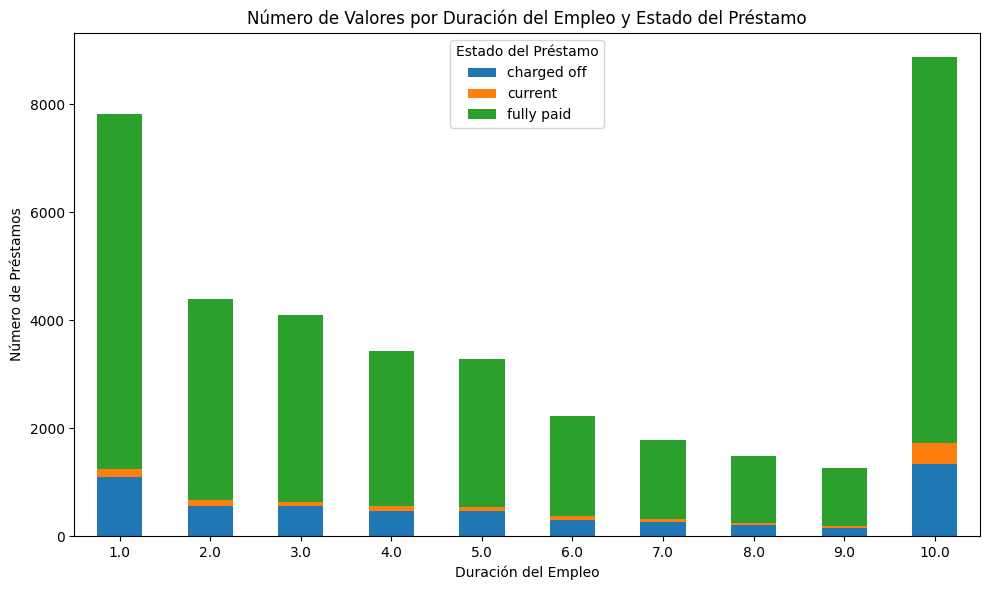

In [227]:
# Valores de 'employment_length' discriminando por 'loan_status'
pivot_df = df.pivot_table(index='employment_length', columns='loan_status', aggfunc='size', dropna=True)

# Crear el gráfico de barras apiladas
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configuración del gráfico
plt.xlabel('Duración del Empleo')
plt.ylabel('Número de Préstamos')
plt.title('Número de Valores por Duración del Empleo y Estado del Préstamo')
plt.legend(title='Estado del Préstamo')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Veamos ahora un dataset con los datos de 'employment_length' Nan, para ver si podemos establecer algún criterio para asignar estos valores.

In [228]:
df[df['employment_length'].isna()].head(10)

,id,loan_status,loan_amount,loan_term,interest_rate,installment,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
168,1067644,charged off,2500,36,7.51,77.78,a,source verified,debt_consolidation,16.30,2,13,0,42.2,20,NaN,own,12000.0
323,1058717,fully paid,18000,60,17.58,452.98,d,verified,debt_consolidation,21.96,1,11,0,83.7,28,NaN,mortgage,60000.0
394,1064582,fully paid,4000,36,11.71,132.31,b,source verified,home_improvement,7.50,0,4,0,54.9,6,NaN,rent,24000.0
422,1064366,charged off,1000,36,14.65,34.50,c,not verified,major_purchase,6.00,2,3,1,83.7,8,NaN,rent,18408.0
439,1063912,fully paid,8250,36,7.51,256.67,a,verified,debt_consolidation,17.87,4,17,0,10.4,37,NaN,mortgage,31500.0
534,1062897,charged off,1700,36,7.90,53.20,a,not verified,home_improvement,27.00,0,9,0,91.2,27,NaN,mortgage,37800.0
555,1062781,fully paid,5000,36,8.90,158.77,a,source verified,other,16.17,0,9,0,53.0,32,NaN,mortgage,70000.0
562,1062535,fully paid,3000,36,9.91,96.68,b,not verified,renewable_energy,4.29,0,3,0,33.3,3,NaN,mortgage,42000.0
569,1036838,charged off,8575,36,17.58,308.21,d,verified,debt_consolidation,22.54,1,4,0,89.9,5,NaN,mortgage,32000.0
678,1061194,fully paid,5600,36,6.03,170.44,a,not verified,car,3.97,0,17,0,2.7,44,NaN,own,41100.0


No parece haber un criterio claro para asignar los Nan de esta columna. Ya que representan un porcentaje pequeño de nuestro dataset, vamos a proceder a eliminarlos.

In [229]:
df.dropna(subset=['employment_length'], inplace=True)

## Análisis

In [230]:
variables_continuas = ['loan_amount', 'interest_rate', 'installment', 'dti', 'revolving_rate', 'annual_income']

In [231]:
variables_categoricas = ['id', 'loan_status', 'grade', 'verification_status', 'purpose', 'home_ownership']
variables_categoricas.remove('id')
variables_categoricas

['loan_status', 'grade', 'verification_status', 'purpose', 'home_ownership']

In [232]:
# Variables numéricas discretas
variables_discretas = ['loan_term', 'inquiries', 'open_credit_lines', 'derogatory', 'total_credit_lines', 'employment_length', 'loan_status']

### Análisis Univariante y Bivariante

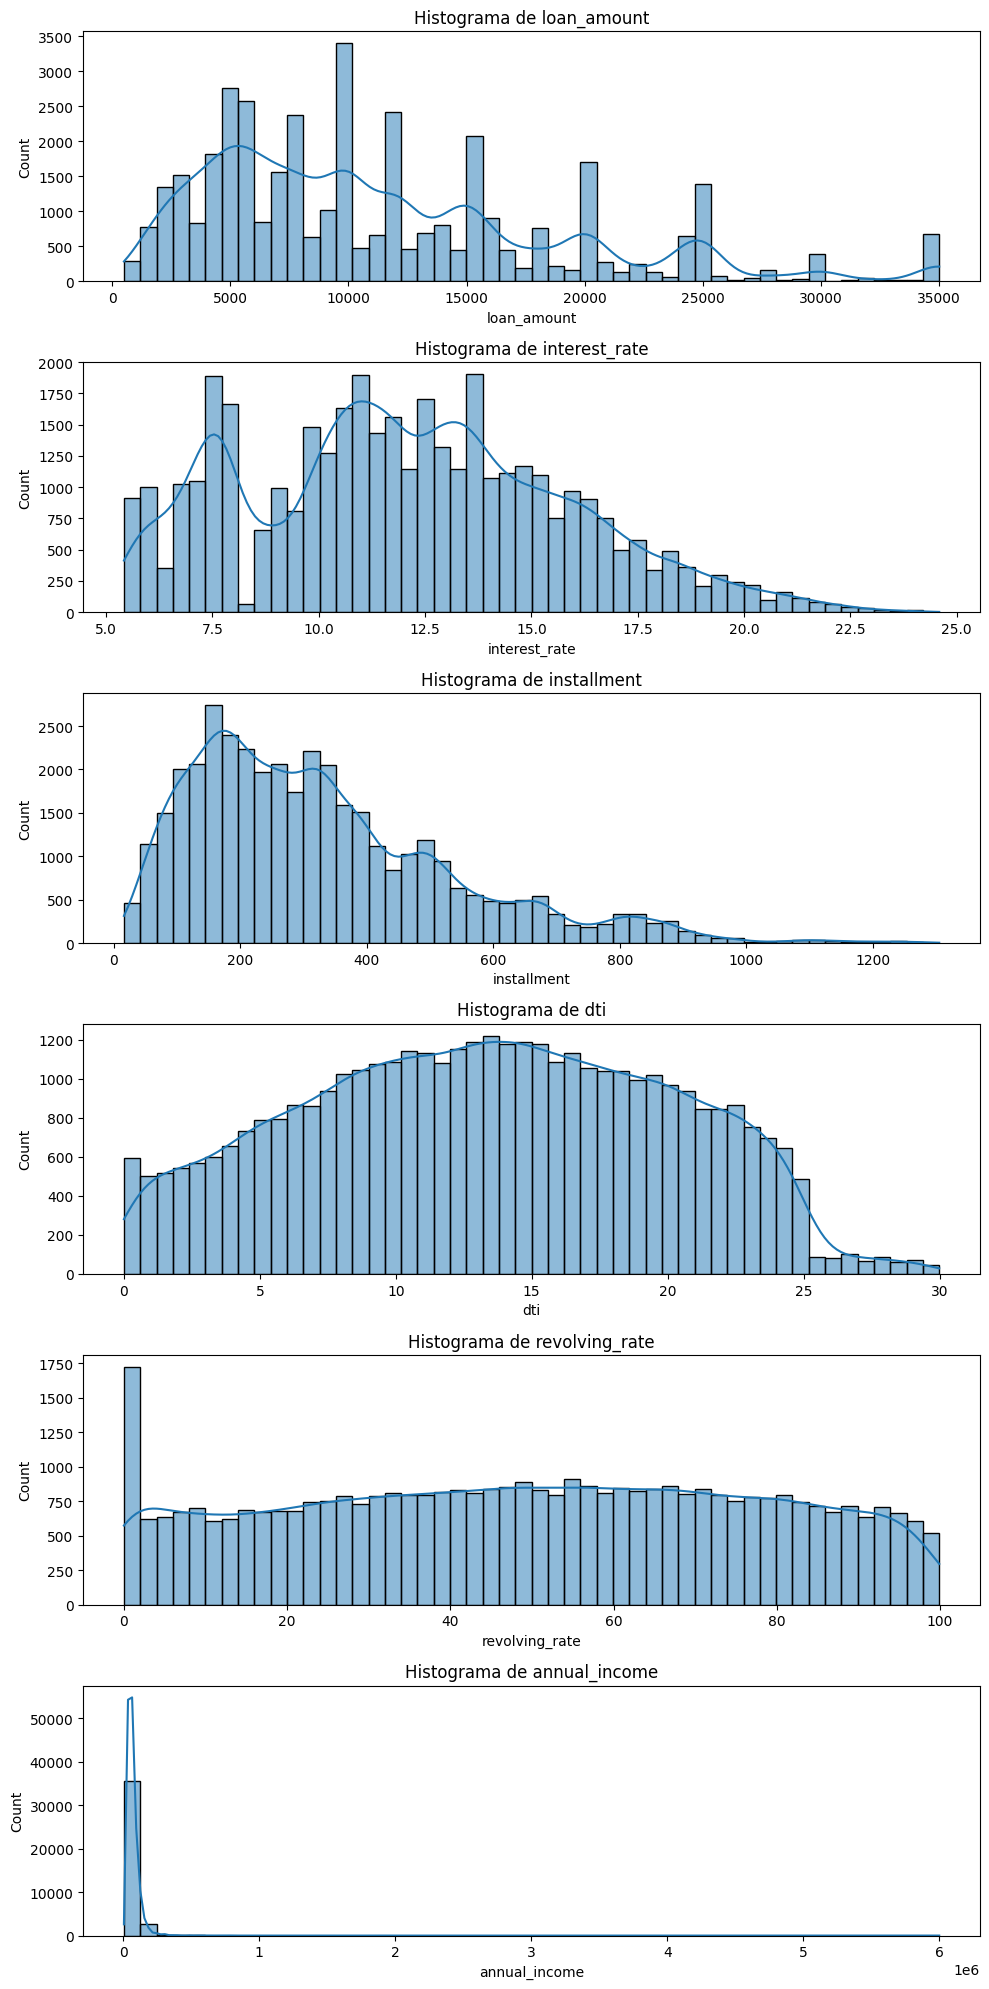

In [233]:
# Crear subplots
fig, axs = plt.subplots(nrows=len(variables_continuas), figsize=(10, 20))

# Iterar sobre las columnas continuas
for i, columna in enumerate(variables_continuas):
    # Histograma con función de densidad de probabilidad
    sns.histplot(df[columna], bins=50, kde=True, ax=axs[i])
    axs[i].set_title(f'Histograma de {columna}')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

Las variables 'loan_amount', 'interest_rate', 'installment' y 'annual_income' tienen cierta asimetria, veamos como quedarian con una escala logaritmica

In [234]:
columnas_log = ['loan_amount', 'interest_rate', 'installment', 'annual_income']

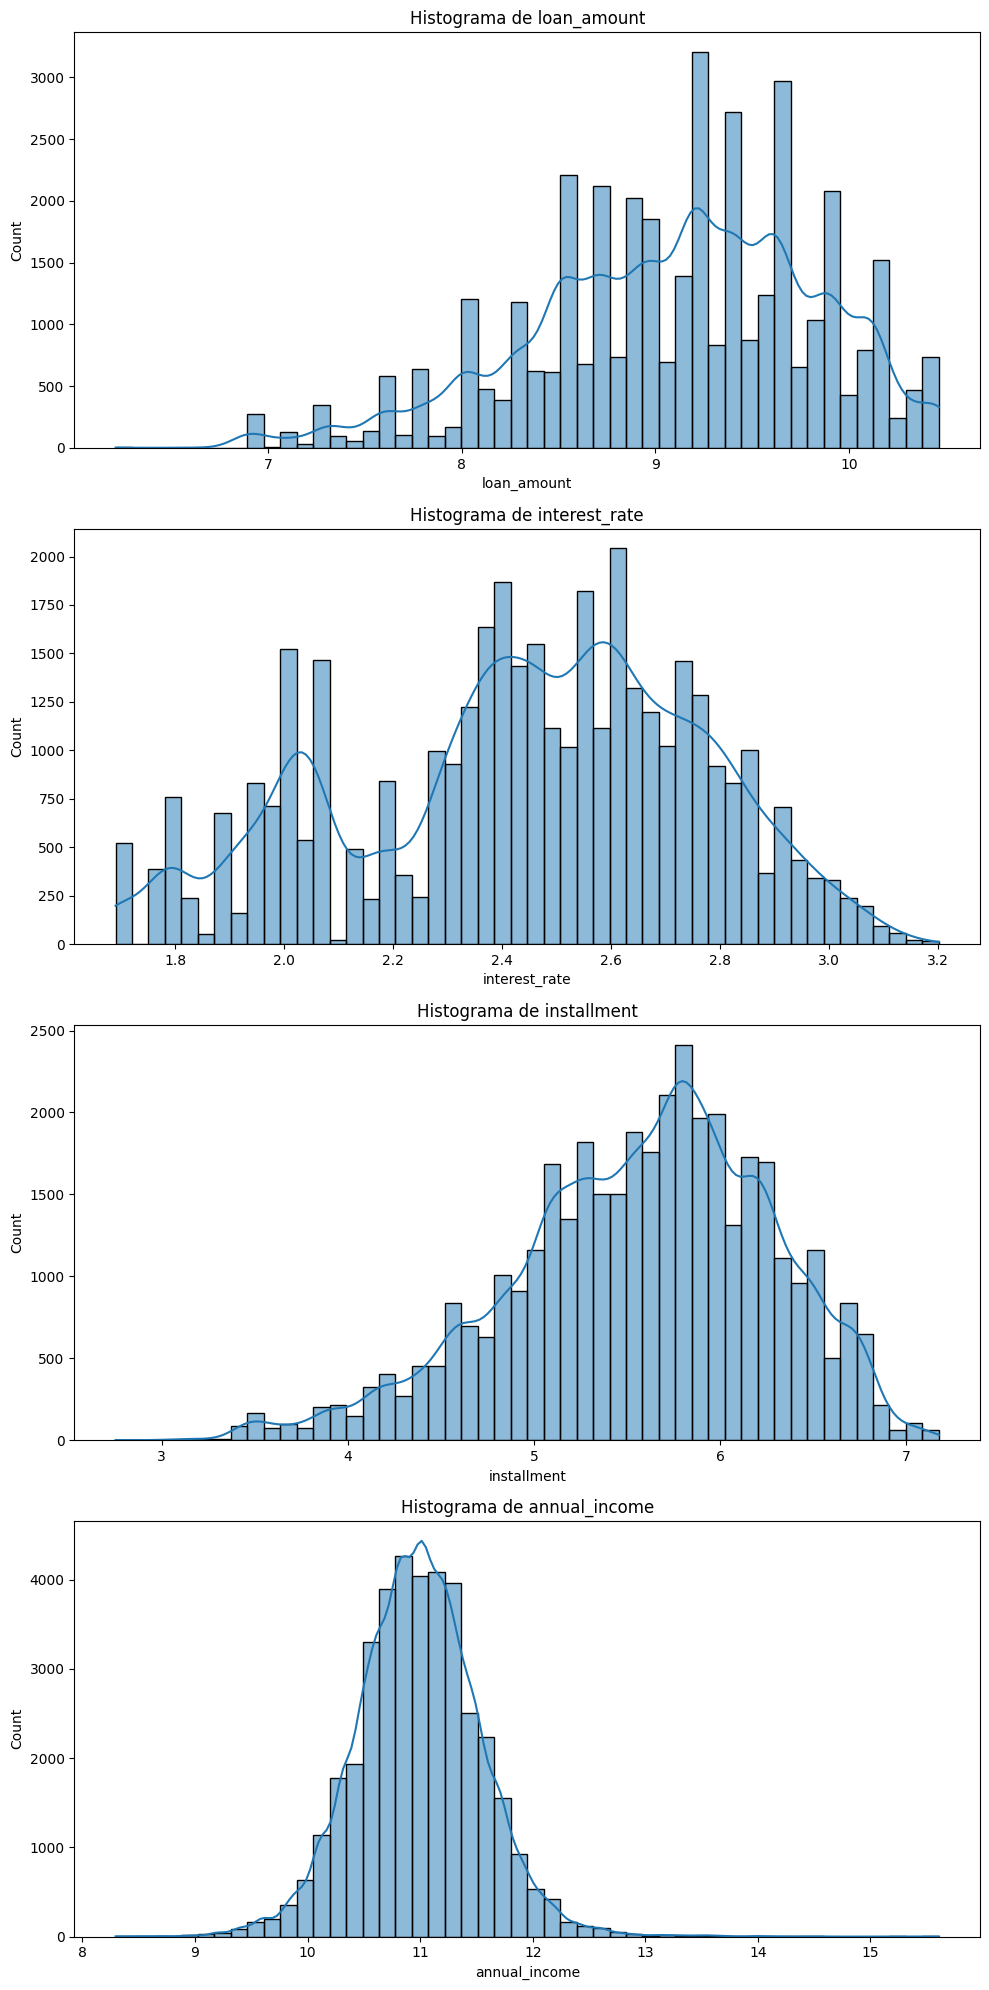

In [235]:
fig, axs = plt.subplots(nrows=len(columnas_log), figsize=(10, 20))

# Iterar sobre las columnas continuas
for i, columna in enumerate(columnas_log):
    # Histograma con función de densidad de probabilidad
    sns.histplot(np.log(df[columna]), bins=50, kde=True, ax=axs[i])
    axs[i].set_title(f'Histograma de {columna}')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

Vamos a convertir a escala logaritmica solo la columna 'annual_income'

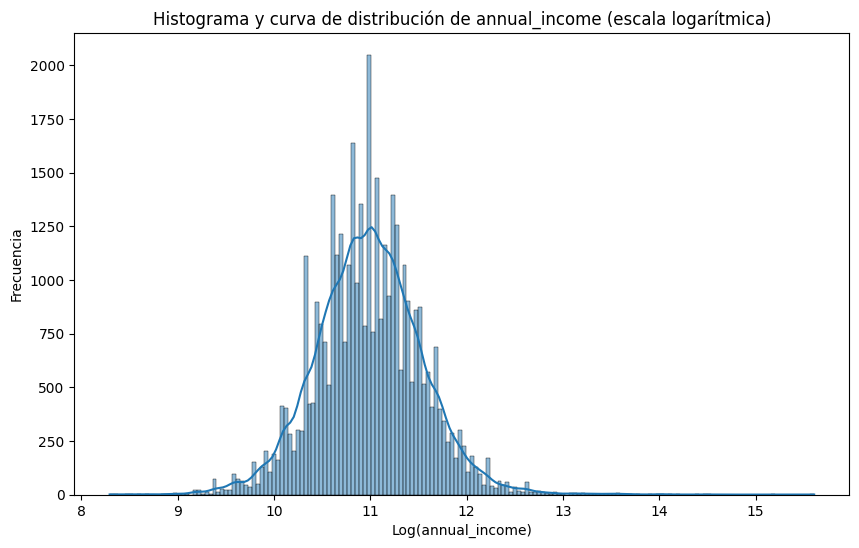

In [236]:
# Escalar 'annual_income' a escala logarítmica
df['annual_income'] = np.log(df['annual_income'])

# Histograma con función de densidad de probabilidad
plt.figure(figsize=(10, 6))
sns.histplot(df['annual_income'], kde=True)
plt.title('Histograma y curva de distribución de annual_income (escala logarítmica)')
plt.xlabel('Log(annual_income)')
plt.ylabel('Frecuencia')
plt.show()

### Búsqueda y sustitución de outliers

El siguiente paso es buscar posibles outliers o valores atípicos. Para detectar posibles valores atípicos usamos gráficos de tipo boxplot, en las variables que sean cuantitativas contínuas.

Vemos los valores únicos de cada columna

In [237]:
for columna in df.columns:
    num_valores_unicos = df[columna].nunique()
    print(f"La columna '{columna}' tiene {num_valores_unicos} valores únicos.")

La columna 'id' tiene 38642 valores únicos.
La columna 'loan_status' tiene 3 valores únicos.
La columna 'loan_amount' tiene 880 valores únicos.
La columna 'loan_term' tiene 2 valores únicos.
La columna 'interest_rate' tiene 371 valores únicos.
La columna 'installment' tiene 15149 valores únicos.
La columna 'grade' tiene 7 valores únicos.
La columna 'verification_status' tiene 3 valores únicos.
La columna 'purpose' tiene 14 valores únicos.
La columna 'dti' tiene 2863 valores únicos.
La columna 'inquiries' tiene 9 valores únicos.
La columna 'open_credit_lines' tiene 40 valores únicos.
La columna 'derogatory' tiene 5 valores únicos.
La columna 'revolving_rate' tiene 1087 valores únicos.
La columna 'total_credit_lines' tiene 82 valores únicos.
La columna 'employment_length' tiene 10 valores únicos.
La columna 'home_ownership' tiene 5 valores únicos.
La columna 'annual_income' tiene 5100 valores únicos.


In [238]:
columnas_continuas = []

for columna in df.columns:
    if df[columna].nunique() > 100:
        columnas_continuas.append(columna)

        

In [239]:
columnas_continuas.remove('id')
columnas_continuas

['loan_amount',
 'interest_rate',
 'installment',
 'dti',
 'revolving_rate',
 'annual_income']

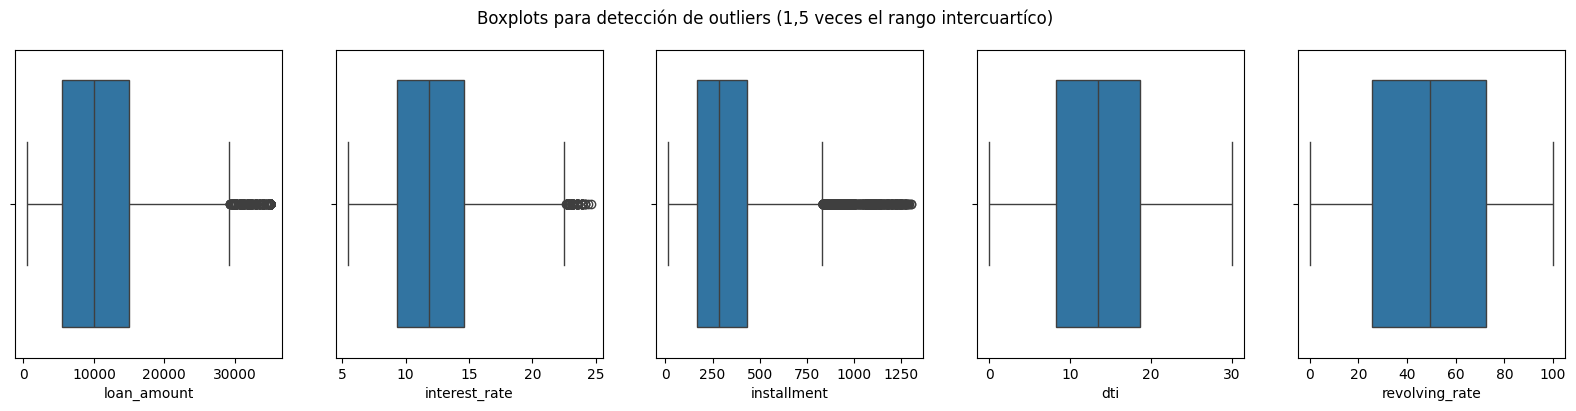

In [240]:
# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Boxplots para detección de outliers (1,5 veces el rango intercuartíco)')
sns.boxplot(ax=axes[0], x=df[columnas_continuas[0]])
sns.boxplot(ax=axes[1], x=df[columnas_continuas[1]])
sns.boxplot(ax=axes[2], x=df[columnas_continuas[2]])
sns.boxplot(ax=axes[3], x=df[columnas_continuas[3]])
sns.boxplot(ax=axes[4], x=df[columnas_continuas[4]])
plt.show();

Por la gráfica, vemos que tanto las columnas 'dti' o 'revolving_rate' no tiene outliers apreciables. Las otras 3 columnas, y sobre todo la columna 'annual_income' parecen tener elevados valores fuera del rango del 1,5 * rango intercuartílico

In [241]:
df[columnas_continuas].describe().round(2)

,loan_amount,interest_rate,installment,dti,revolving_rate,annual_income
count,38642.00,38642.00,38642.00,38642.00,38642.00,38642.00
mean,11291.62,12.05,326.76,13.33,48.94,10.99
std,7462.14,3.72,209.14,6.67,28.34,0.55
min,500.00,5.42,15.69,0.00,0.00,8.29
25%,5500.00,9.32,168.44,8.20,25.50,10.63
50%,10000.00,11.86,282.83,13.42,49.50,11.00
75%,15000.00,14.59,434.40,18.59,72.50,11.33
max,35000.00,24.59,1305.19,29.99,99.90,15.61


Vamos a volver a realizar un gráfico boxplot para las columnas 'loan_amount', 'interest_rate' y 'annual_income', pero tomando con outliers la cantidad de 6 veces el rango intercuartílico, a fin de disminuir la cantidad de valores que dejamos fuera como consecuencia de tomar el 1,5 * rango intercuartílico

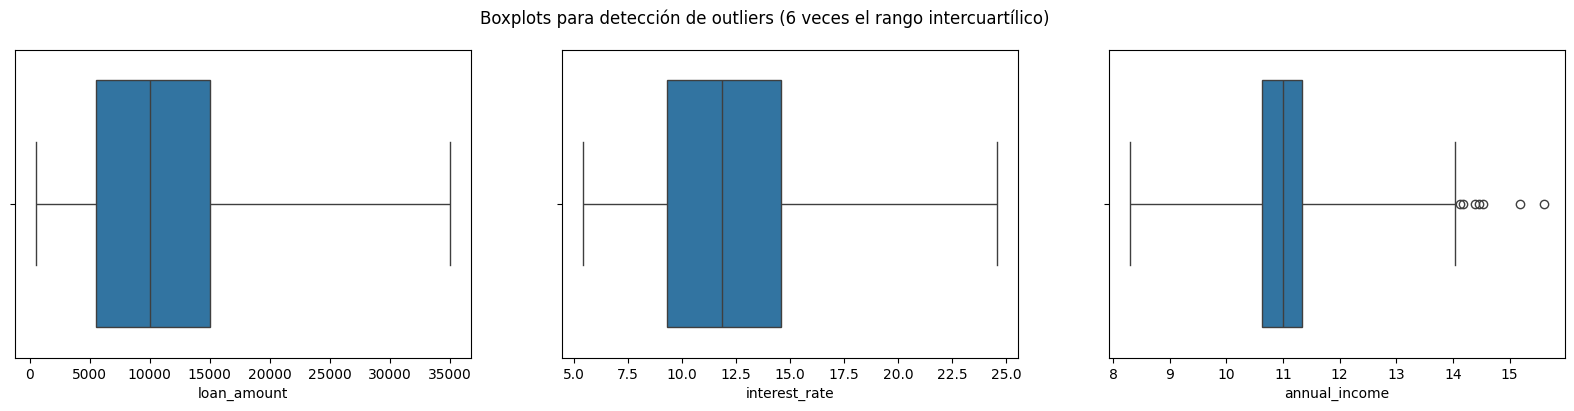

In [242]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas_2 = ['loan_amount', 'interest_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Boxplots para detección de outliers (6 veces el rango intercuartílico)')
sns.boxplot(ax=axes[0], x=df[columnas_continuas_2[0]], whis=4)
sns.boxplot(ax=axes[1], x=df[columnas_continuas_2[1]], whis=4)
sns.boxplot(ax=axes[2], x=df[columnas_continuas_2[2]], whis=4)

plt.show();

Aumentando a 4 las veces del rango intercuartílico para considerar un valor como outlier resolvemos la existencia de outliers en las columnas 'loan_amount' y 'interest_rate', pero seguimos teniendo muchos valores como outliers en la columna 'annual_income'. Vamos a estudiar con detenimiento cuántos valores son y de qué importes estamos hablando en esta columna.

In [243]:
q1_income = df['annual_income'].quantile(0.25)
q3_income = df['annual_income'].quantile(0.75)
iqr_income = q3_income - q1_income
upper_income = q3_income + 4 * iqr_income
lower_income = q1_income - 4 * iqr_income

In [244]:
df[df['annual_income'] > upper_income]['annual_income'].describe().round(2)

count     7.00
mean     14.64
std       0.55
min      14.12
25%      14.29
50%      14.46
75%      14.85
max      15.61
Name: annual_income, dtype: float64

In [245]:
df[df['annual_income'] < lower_income]['annual_income'].describe().round(2)

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: annual_income, dtype: float64

In [246]:
df.shape

(38642, 18)

Vemos que los valores que superan las 4 veces el rango intercuartílico de la columna 'annual_income' son 7 valores de 38.642 (0,018 %). El importe mínimo de este grupo es de
14.12, y el máximo es de 15.61. 
Vamos a optar por asignar a todos los valores de la columna 'annual_income" que superen los 14.12 este valor.

In [247]:
iqr_factor = 4
q1 = df['annual_income'].quantile(0.25)
q3 = df['annual_income'].quantile(0.75)
iqr = q3 - q1
upper_threshold = q3 + (iqr_factor * iqr)
lower_threshold = q1 - (iqr_factor * iqr)
print('ingreso anual')
print('q1:', q1)
print('q3:', q3)
print('umbral superior:', upper_threshold)
print('umbral inferior', lower_threshold)

# Reasignar valores 
df.loc[df['annual_income'] > upper_threshold, 'annual_income'] = upper_threshold
# df.loc[df['annual_income'] < lower_threshold, 'annual_income'] = lower_threshold
print(df['annual_income'].describe().round(2))

ingreso anual
q1: 10.631036159813405
q3: 11.329002506616964
umbral superior: 14.120867893831202
umbral inferior 7.839170772599168
count    38642.00
mean        10.99
std          0.55
min          8.29
25%         10.63
50%         11.00
75%         11.33
max         14.12
Name: annual_income, dtype: float64


Volvemos a hacer el gráfico de boxplots inicial, pero con un factor 4 por el rango intercuartílico

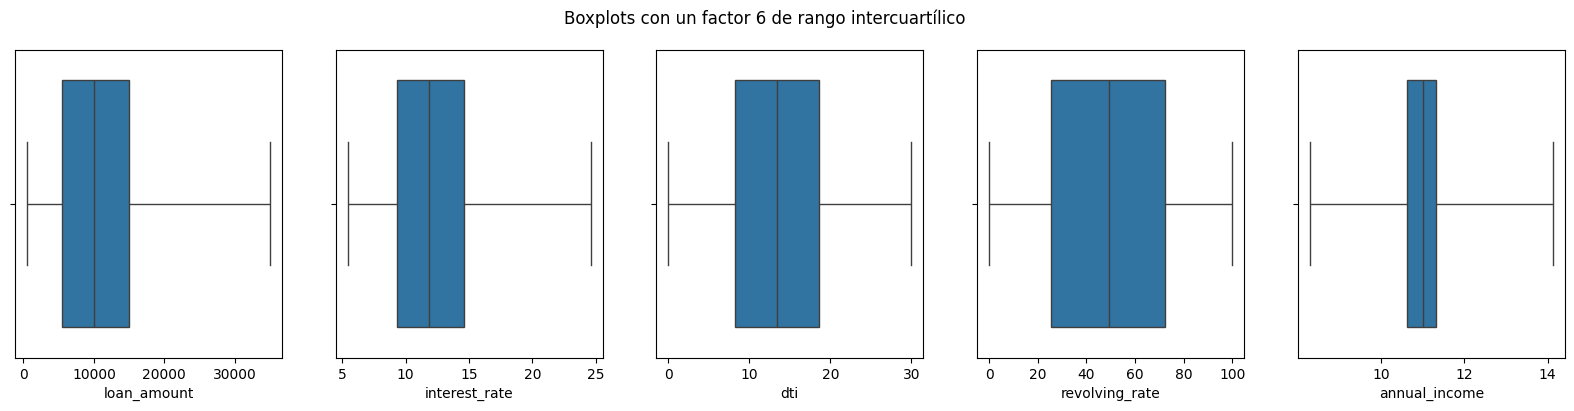

In [248]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas = ['loan_amount', 'interest_rate', 'dti', 'revolving_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Boxplots con un factor 6 de rango intercuartílico')
sns.boxplot(ax=axes[0], x=df[columnas_continuas[0]], whis=4)
sns.boxplot(ax=axes[1], x=df[columnas_continuas[1]], whis=4)
sns.boxplot(ax=axes[2], x=df[columnas_continuas[2]], whis=4)
sns.boxplot(ax=axes[3], x=df[columnas_continuas[3]], whis=4)
sns.boxplot(ax=axes[4], x=df[columnas_continuas[4]], whis=4)

plt.show();

Vemos que ahora ya no tenemos outliers extremos

Vamos a analizar ahora las columnas categoricas

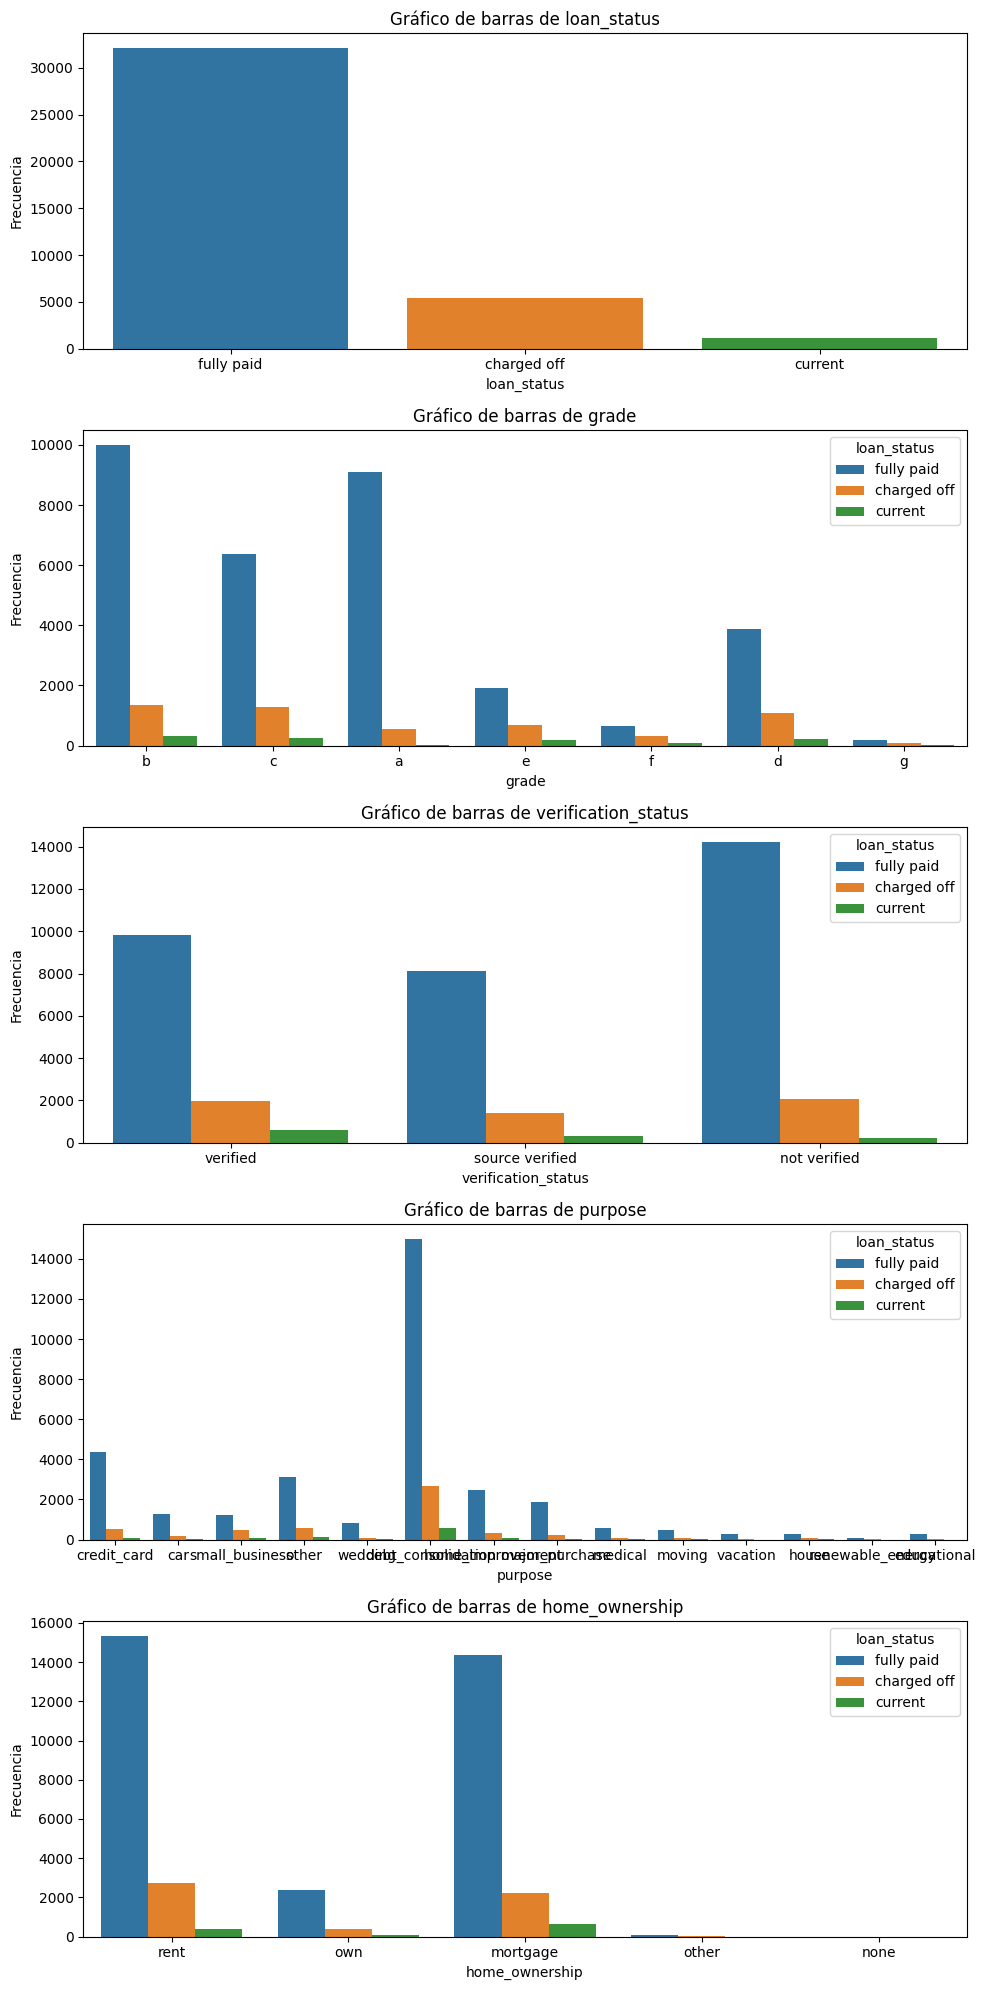

In [249]:
# Crear subplots
fig, axs = plt.subplots(nrows=len(variables_categoricas), figsize=(10, 20))

# Iterar sobre las columnas categóricas
for i, columna in enumerate(variables_categoricas):
    # Gráfico de barras
    sns.countplot(x=columna, data=df, ax=axs[i], hue='loan_status')
    axs[i].set_title(f'Gráfico de barras de {columna}')
    axs[i].set_xlabel(columna)
    axs[i].set_ylabel('Frecuencia')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

Vamos ahora con las variables discretas

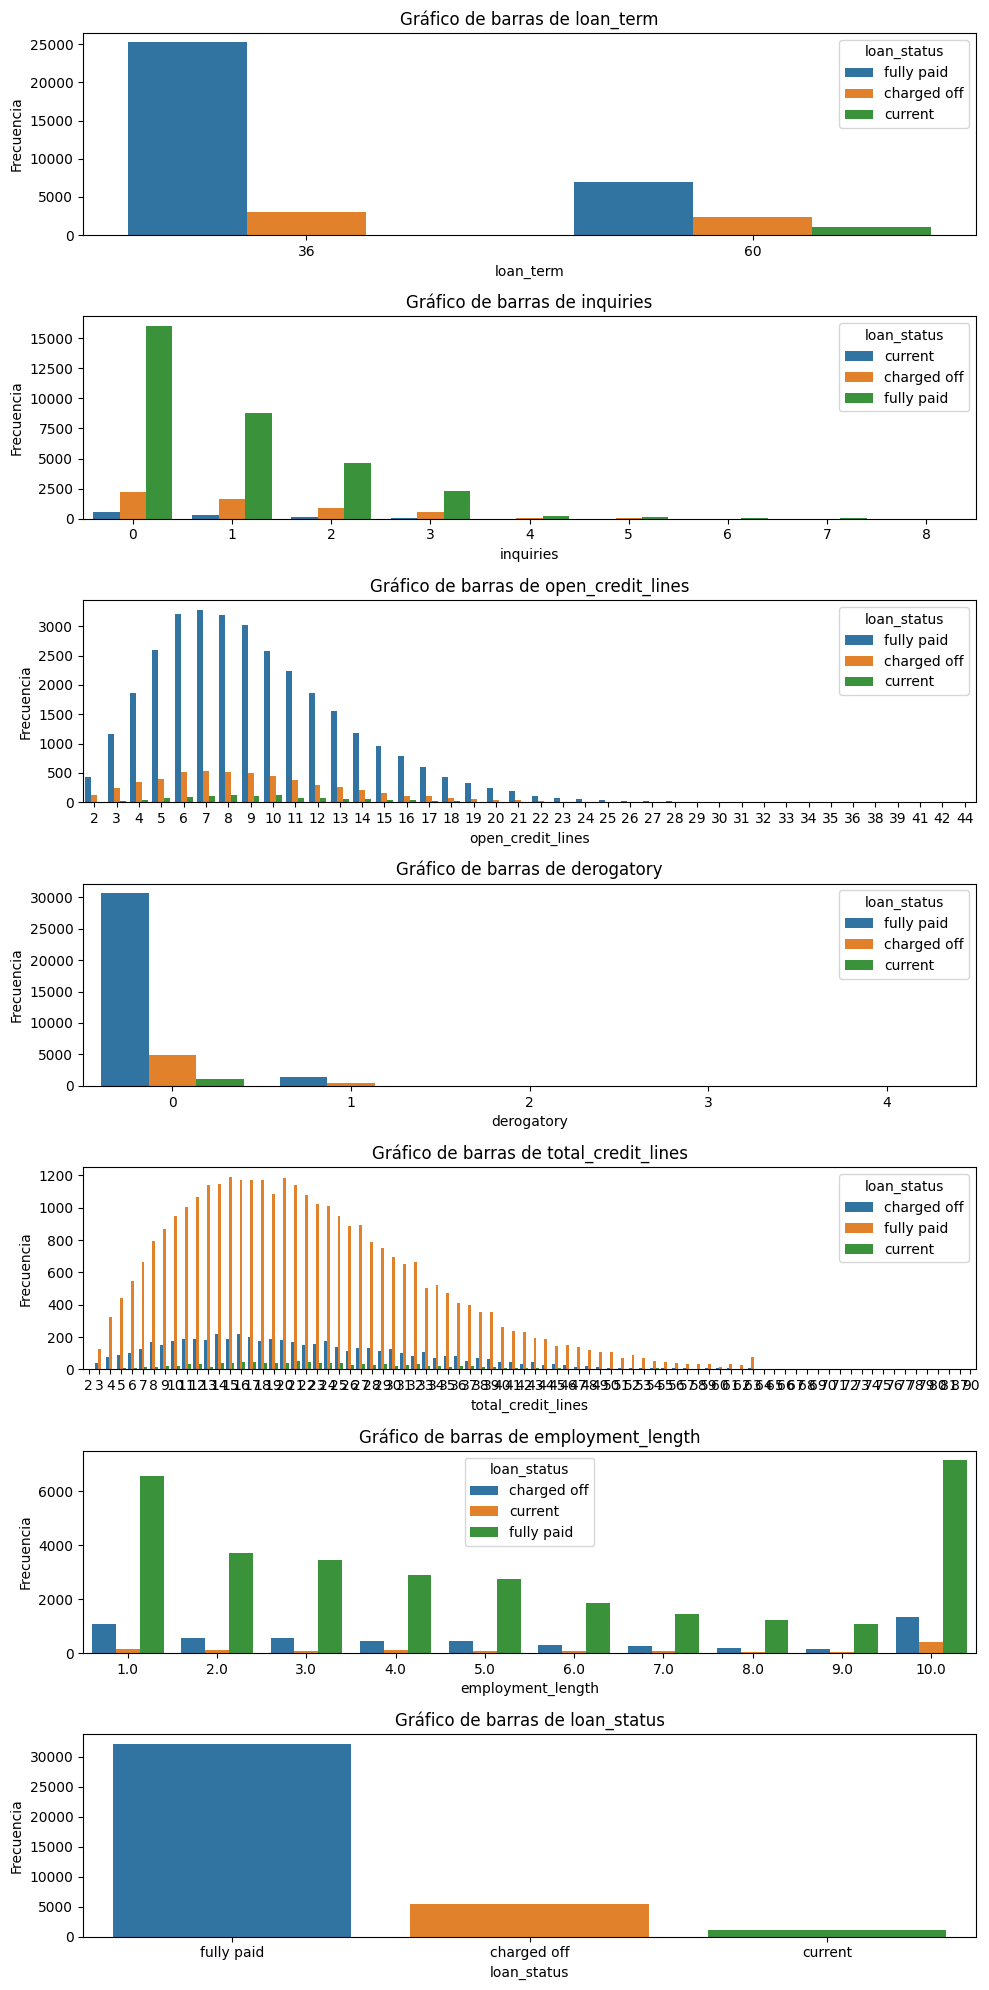

In [250]:
# Crear subplots
fig, axs = plt.subplots(nrows=len(variables_discretas), figsize=(10, 20))

# Iterar sobre las columnas categóricas
for i, columna in enumerate(variables_discretas):
    # Gráfico de barras
    sns.countplot(x=columna, data=df, ax=axs[i], hue='loan_status')
    axs[i].set_title(f'Gráfico de barras de {columna}')
    axs[i].set_xlabel(columna)
    axs[i].set_ylabel('Frecuencia')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

## Análisis Multivariante

Veamos en primer lugar la correlación existente entre las variables numéricas de nuestro dataset

In [251]:
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,id,loan_amount,loan_term,interest_rate,installment,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income
id,1.000000,0.146473,0.223575,0.083189,0.090195,0.095810,-0.041859,0.022344,-0.021260,0.099719,0.043521,0.113486,0.049584
loan_amount,0.146473,1.000000,0.360159,0.307613,0.929744,0.065482,0.009495,0.173790,-0.047820,0.066844,0.255794,0.154473,0.438996
loan_term,0.223575,0.360159,1.000000,0.452545,0.099743,0.084188,0.041437,0.050285,0.009099,0.071972,0.095913,0.113383,0.091164
interest_rate,0.083189,0.307613,0.452545,1.000000,0.280382,0.112549,0.132270,0.012251,0.097358,0.462711,-0.042191,0.005765,0.071303
installment,0.090195,0.929744,0.099743,0.280382,1.000000,0.053055,0.010025,0.169612,-0.043158,0.095824,0.230145,0.124807,0.435205
dti,0.095810,0.065482,0.084188,0.112549,0.053055,1.000000,-0.000275,0.289219,-0.004945,0.278734,0.230755,0.051119,-0.108784
inquiries,-0.041859,0.009495,0.041437,0.132270,0.010025,-0.000275,1.000000,0.092114,0.024579,-0.068584,0.112005,0.008623,0.041303
open_credit_lines,0.022344,0.173790,0.050285,0.012251,0.169612,0.289219,0.092114,1.000000,0.002791,-0.085271,0.685576,0.097383,0.281684
derogatory,-0.021260,-0.047820,0.009099,0.097358,-0.043158,-0.004945,0.024579,0.002791,1.000000,0.058041,-0.020014,0.062175,-0.007968
revolving_rate,0.099719,0.066844,0.071972,0.462711,0.095824,0.278734,-0.068584,-0.085271,0.058041,1.000000,-0.065761,0.012980,0.047506


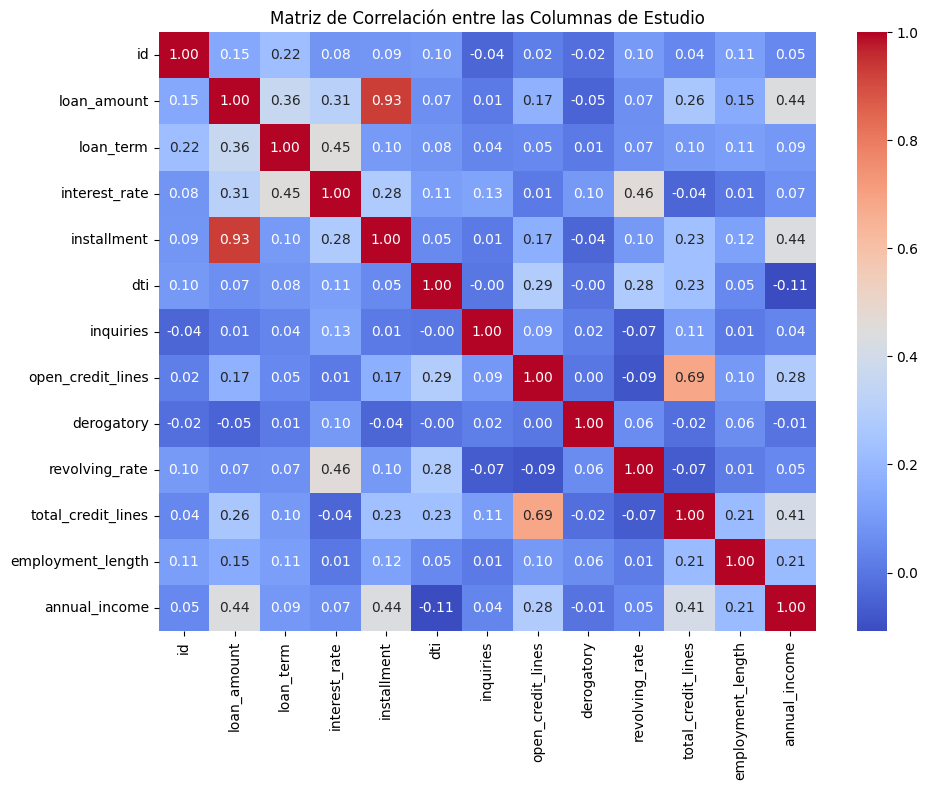

In [252]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre las Columnas de Estudio')
plt.tight_layout()
plt.show()

Como vemos la correlación entre las variables numéricas es muy baja, con la excepción de la correlación entre el importe del préstamo y la cuota pagada (lo cual tiene todo el sentido).

Cabe mencionar alguna relación entre el tipo de interés y la tasa de revolving, entre los ingresos anuales y la cuota pagada, y entre los ingresos anuales y el importe del préstamo

Vemos gráficamente estas relaciones

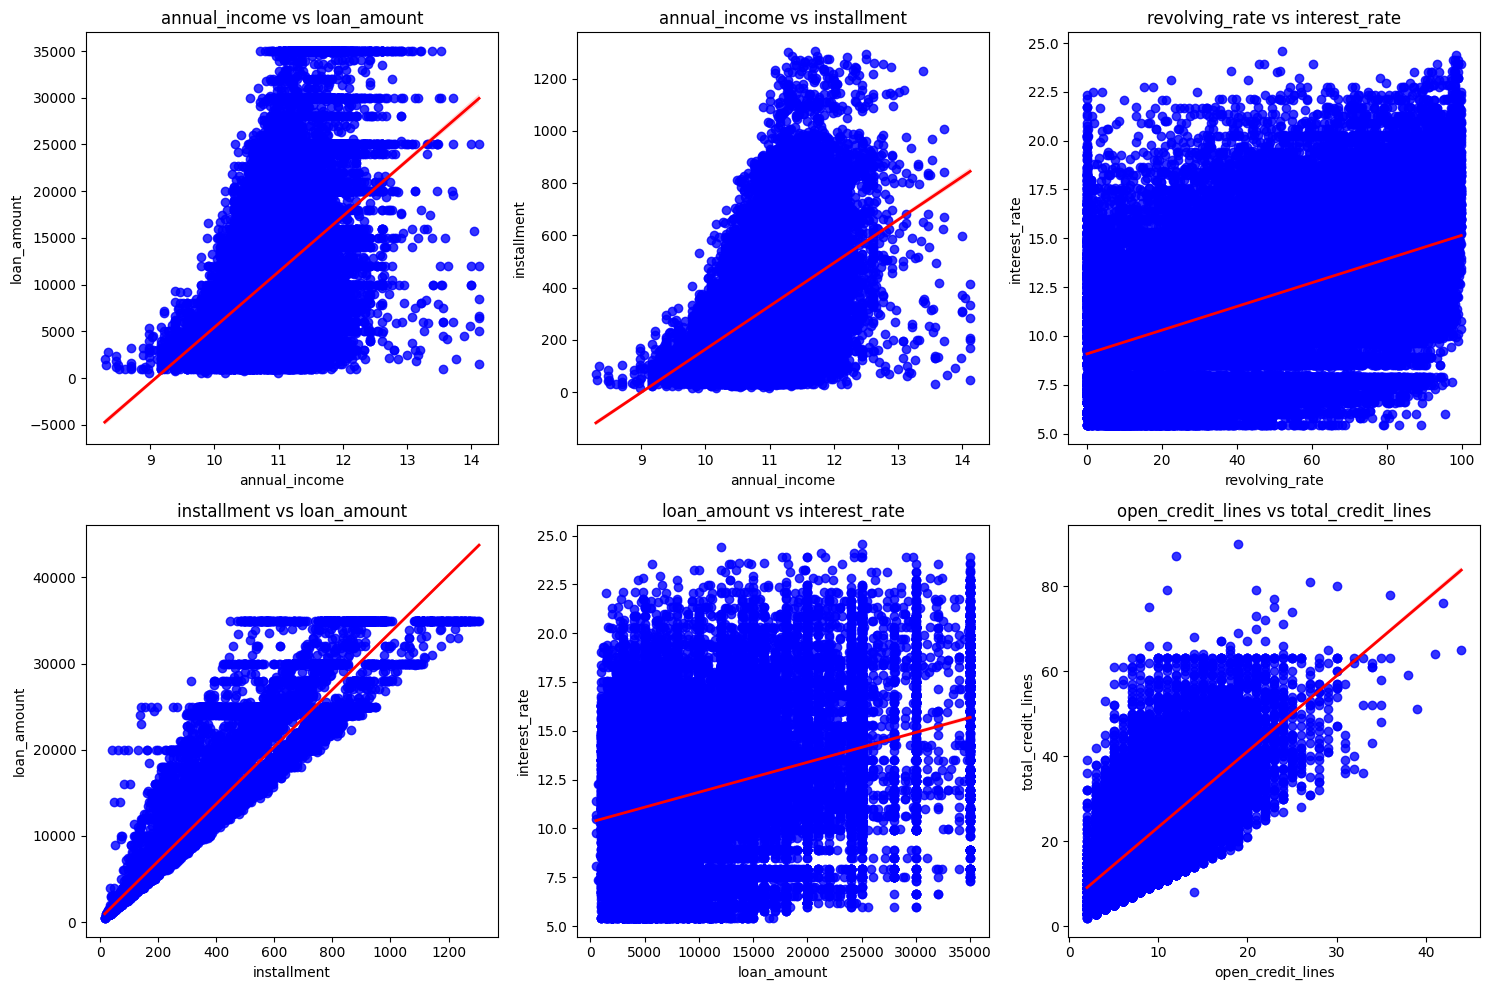

In [253]:
# Definir las columnas para el estudio
columnas_estudio = ['loan_amount', 'interest_rate', 'installment', 'revolving_rate', 'annual_income', 'dti', 'open_credit_lines', 'total_credit_lines']

# Seleccionar solo las columnas de interés del DataFrame
df_estudio = df[columnas_estudio]

# Crear un subplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Definir las combinaciones de columnas y sus posiciones en el subplot
columnas_combinaciones = [
    ('annual_income', 'loan_amount'),
    ('annual_income', 'installment'),
    ('revolving_rate', 'interest_rate'),
    ('installment', 'loan_amount'),
    ('loan_amount', 'interest_rate'),
    ('open_credit_lines', 'total_credit_lines')
]

# Iterar sobre las combinaciones y trazar gráficos de dispersión con línea de tendencia
for i, combinacion in enumerate(columnas_combinaciones):
    row = i // 3
    col = i % 3
    sns.regplot(x=combinacion[0], y=combinacion[1], data=df_estudio, ax=axs[row, col], scatter_kws={"color": "blue"}, line_kws={"color":"red","linewidth":2})
    axs[row, col].set_title(f'{combinacion[0]} vs {combinacion[1]}')

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

Eliminamos las columnas 'installment' y 'open_credit_lines' por estar muy relacionadas con las columnas 'total_amount' y 'total_credit_lines' respectivamente

In [254]:
df.drop(columns=['installment', 'open_credit_lines'], inplace=True)

Con esto damos por finalizado las transformaciones inicial

In [255]:
df_final_clean = df.copy()
df_final_clean.to_csv('../data/processed/df_final_clean.csv', index=False)

Una vez que tenemos el dataset limpio, vamos a proceder a dividirlo en 2 distinguiendo entre si crédito está todavía en vigor "current" o no
* df_final_current: comprende el dataframe limpio pero con solo con los créditos pagados en vigor
* df_final_no_current: dataframe limpio con todos los créditos ya vencidos


In [256]:
df_final_current = df[df['loan_status'] == 'current']
df_final_current.drop(columns='loan_status', inplace=True)
df_final_current.to_csv('../data/processed/df_final_current.csv', index=False)

In [257]:
df_final = df[df['loan_status'] != 'current']


In [258]:
# Mapeamos los valores de 'loan_status' a 1 si es 'charged off' y 0 si es 'fully paid'
df_final['loan_status'] = df_final['loan_status'].map({'charged off': 1, 'fully paid': 0})

In [259]:
df_final.to_csv('../data/processed/df_final.csv', index=False)

In [260]:
df_final.head()

,id,loan_status,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,1077501,0,5000,36,10.65,b,verified,credit_card,27.65,1,0,83.7,9,10.0,rent,10.085809
1,1077430,1,2500,60,15.27,c,source verified,car,1.00,5,0,9.4,4,1.0,rent,10.308953
2,1077175,0,2400,36,15.96,c,not verified,small_business,8.72,2,0,98.5,10,10.0,rent,9.413444
3,1076863,0,10000,36,13.49,c,source verified,other,20.00,1,0,21.0,37,10.0,rent,10.803649
5,1075269,0,5000,36,7.90,a,source verified,wedding,11.20,3,0,28.3,12,3.0,rent,10.491274


El daset 'df_final_current' son los préstamos vigentes, y vamos a tratar de predecir si estos préstamos van a ser pagados o impagados con nuestro modelo de Machine Learning

Con el dataset 'df_final_due' es con el que vamos a entrenar y hacer pruebas para elegir el modelo

In [261]:
df = df_final.copy()

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37544 entries, 0 to 39716
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   37544 non-null  int64  
 1   loan_status          37544 non-null  int64  
 2   loan_amount          37544 non-null  int64  
 3   loan_term            37544 non-null  int64  
 4   interest_rate        37544 non-null  float64
 5   grade                37544 non-null  object 
 6   verification_status  37544 non-null  object 
 7   purpose              37544 non-null  object 
 8   dti                  37544 non-null  float64
 9   inquiries            37544 non-null  int64  
 10  derogatory           37544 non-null  int64  
 11  revolving_rate       37544 non-null  float64
 12  total_credit_lines   37544 non-null  int64  
 13  employment_length    37544 non-null  float64
 14  home_ownership       37544 non-null  object 
 15  annual_income        37544 non-null  floa

## MACHINE LEARNING ##

Veamos primero si la variable objetivo está desbalanceada

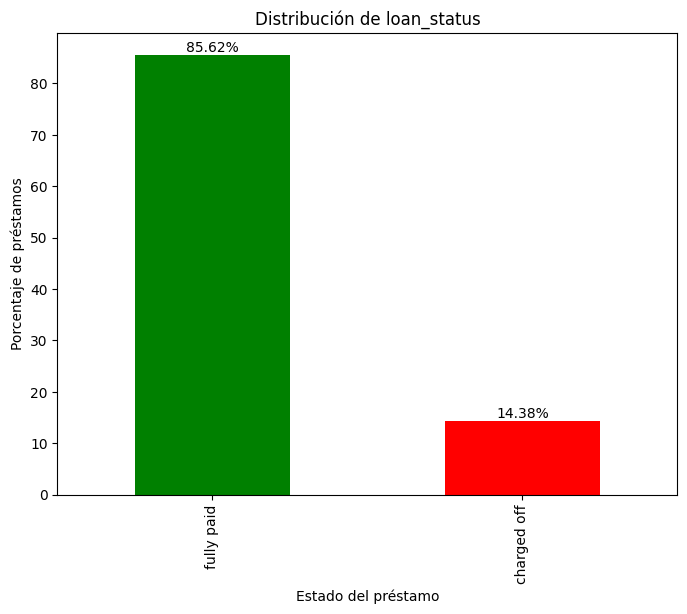

In [263]:
# Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
ax = df['loan_status'].value_counts(normalize=True).mul(100).round(2).plot(kind='bar', color=['green', 'red'])

# Añadimos título y etiquetas


plt.title('Distribución de loan_status')
plt.xlabel('Estado del préstamo')
plt.ylabel('Porcentaje de préstamos')

plt.xticks(ticks=[0, 1], labels=['fully paid', 'charged off'])

# Añadimos los porcentajes relativos encima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Cómo vemos, aunque están desbalanceados, no es tan relevante como para que tengamos que hace mayores transformaciones al dataset. 

No obastante, estratificaremos los datos de entrenamiento y prueba y aplicaremos el balanceado al cross validation en los modelos que lo permitan

In [264]:
df.head(5)

,id,loan_status,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,1077501,0,5000,36,10.65,b,verified,credit_card,27.65,1,0,83.7,9,10.0,rent,10.085809
1,1077430,1,2500,60,15.27,c,source verified,car,1.00,5,0,9.4,4,1.0,rent,10.308953
2,1077175,0,2400,36,15.96,c,not verified,small_business,8.72,2,0,98.5,10,10.0,rent,9.413444
3,1076863,0,10000,36,13.49,c,source verified,other,20.00,1,0,21.0,37,10.0,rent,10.803649
5,1075269,0,5000,36,7.90,a,source verified,wedding,11.20,3,0,28.3,12,3.0,rent,10.491274


Creamos una funcion que nos divida el dataset en el dataset de entrenamiento y el de prueba

In [265]:
def dividir_dataset(df, test_size=0.25, random_state=None, target='loan_status', no_incluir='id'):
    """
    Función para dividir un DataFrame en conjuntos de entrenamiento y prueba.

    Args:
    - df: DataFrame que se desea dividir.
    - test_size: Porcentaje del dataset que se desea asignar al conjunto de prueba. Por defecto, es 0.25.
    - random_state: Semilla para la generación de números aleatorios. Por defecto, es None.

    Returns:
    - train_set: DataFrame de entrenamiento.
    - test_set: DataFrame de prueba.
    """
    train_set, test_set = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target])
    X_train_set = train_set.drop(columns=[no_incluir, target])
    X_test_set = test_set.drop(columns=[no_incluir, target])
    y_train_set = train_set[target]
    y_test_set = test_set[target]
    return X_train_set, X_test_set, y_train_set, y_test_set

In [266]:
X_train, X_test, y_train, y_test = dividir_dataset(df, test_size=0.25, random_state=42)

# Imprimir tamaños de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaño del conjunto de entrenamiento: 28158
Tamaño del conjunto de prueba: 9386


In [267]:
X_train.head(5)

,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
25880,5000,36,13.98,c,not verified,debt_consolidation,6.01,1,0,22.6,19,1.0,rent,10.789402
15545,4000,36,10.99,b,source verified,debt_consolidation,13.34,0,0,72.8,17,1.0,rent,11.156251
14857,11000,36,7.49,a,not verified,debt_consolidation,3.37,0,0,32.3,10,4.0,rent,10.736397
21738,8700,36,12.61,c,source verified,debt_consolidation,16.07,0,0,39.3,7,4.0,rent,10.604603
19797,3000,36,10.00,b,source verified,car,19.33,3,0,24.1,14,1.0,rent,9.574983


In [268]:
X_test.head(5)

,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
26,15000,36,14.27,c,not verified,debt_consolidation,15.22,1,0,57.6,11,9.0,rent,11.002100
9429,1400,36,5.42,a,source verified,major_purchase,12.07,0,0,2.7,25,10.0,mortgage,10.896739
13709,18000,60,18.39,e,verified,home_improvement,19.23,0,0,88.4,36,9.0,mortgage,12.013701
30435,10000,36,10.25,b,verified,house,15.50,2,0,10.1,15,2.0,mortgage,11.018629
1271,8000,36,12.42,b,not verified,debt_consolidation,22.02,2,0,66.5,14,3.0,rent,11.002100


Creamos unas listas con las variables categoricas y numericas

In [269]:
# Definir las columnas categóricas y numéricas
categorical_cols = ['grade', 'verification_status', 'purpose', 'home_ownership']
numeric_cols = ['loan_amount', 'loan_term', 'interest_rate', 'dti', 'inquiries',
                'derogatory', 'revolving_rate', 'total_credit_lines', 'employment_length', 'annual_income']

In [270]:
# Crear el preprocesador para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Crear el pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Aplicar el pipeline al conjunto de datos de entrenamiento y prueba
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Obtener los nombres de las columnas después de la transformación OneHotEncoder
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_cols)

# Combinar los nombres de columnas numéricas y categóricas
transformed_feature_names = list(numeric_cols) + list(ohe_feature_names)

# Convertir la salida a DataFrame de pandas
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

In [271]:
X_train_transformed_df.head(5)

,loan_amount,loan_term,interest_rate,dti,inquiries,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income,grade_a,grade_b,grade_c,grade_d,grade_e,grade_f,grade_g,verification_status_not verified,verification_status_source verified,verification_status_verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
0,-0.830950,-0.572347,0.551336,-1.092350,0.116350,-0.22908,-0.922489,-0.273226,-1.196204,-0.348375,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.967062,-0.572347,-0.260398,0.007439,-0.815177,-0.22908,0.847812,-0.448307,-1.196204,0.315701,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.014277,-0.572347,-1.210588,-1.488454,-0.815177,-0.22908,-0.580419,-1.061090,-0.314288,-0.444325,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.327335,-0.572347,0.179405,0.417046,-0.815177,-0.22908,-0.333564,-1.323711,-0.314288,-0.682900,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.103174,-0.572347,-0.529166,0.906175,1.979404,-0.22908,-0.869591,-0.710928,-1.196204,-2.546735,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [272]:
X_test_transformed_df.head(5)

,loan_amount,loan_term,interest_rate,dti,inquiries,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income,grade_a,grade_b,grade_c,grade_d,grade_e,grade_f,grade_g,verification_status_not verified,verification_status_source verified,verification_status_verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
0,0.530171,-0.572347,0.630066,0.289513,0.116350,-0.22908,0.311784,-0.973549,1.155571,0.036655,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.320953,-0.572347,-1.772557,-0.183111,-0.815177,-0.22908,-1.624261,0.252017,1.449543,-0.154070,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.938507,1.747191,1.748576,0.891171,-0.815177,-0.22908,1.397945,1.214961,1.155571,1.867872,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.150389,-0.572347,-0.461295,0.331524,1.047877,-0.22908,-1.363301,-0.623387,-0.902232,0.066577,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.422614,-0.572347,0.127823,1.309781,1.047877,-0.22908,0.625643,-0.710928,-0.608260,0.036655,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [273]:
X_train_transformed_df.shape

(28158, 39)

In [ ]:
X_test_transformed_df.shape

(9386, 39)

### Cross-Validation + Base-Lines ###

Entrenamos diversos modelos para ver con cuales tenemos mejores métricas iniciales

In [ ]:
modelos = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM" : SVC(),
    "Ada Boost": AdaBoostClassifier()
    
}

# Define las métricas a usar
metricas = ["precision", "accuracy", "f1", "recall", "roc_auc"]

resultados_dict = {}

for nombre_modelo, modelo in modelos.items():
    cv_resultados = cross_validate(modelo, X_train_transformed_df, y_train, cv=5, scoring=metricas)
    
    for metrica in metricas:
        clave = f"{nombre_modelo}_{metrica}"
        resultados_dict[clave] = cv_resultados[f"test_{metrica}"].mean()

# Convertir el diccionario de resultados en DataFrame
resultados_df = pd.DataFrame([resultados_dict], columns=resultados_dict.keys())

In [ ]:
resultados_df.T.sort_values(by=0, ascending=False)

,0
Logistic Regression_accuracy,0.856524
Ada Boost_accuracy,0.856275
SVM_accuracy,0.856169
Gradient Boosting_accuracy,0.855920
RandomForestClassifier_accuracy,0.855388
CatBoost_accuracy,0.854393
XGBoost_accuracy,0.849066
Decision Tree_accuracy,0.759038
Logistic Regression_roc_auc,0.704955
Gradient Boosting_roc_auc,0.704069


Vamos a entrenar y ver los resultados con los siguientes modelos:

- Logistic Regression
- SVM
- Random Forest
- XGBoost
- Ada Boost Accuracy

Funciones para métricas

In [ ]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): El modelo del que queremos las métricas
    model_object: a fit GridSearchCV object
    metric (string): roc_auc, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, auc_roc, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'roc_auc': 'mean_test_roc_auc',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 'precision' : 'mean_test_precision'
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    roc_auc = best_estimator_results.mean_test_roc_auc
    accuracy = best_estimator_results.mean_test_accuracy
    precision = best_estimator_results.mean_test_precision

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'roc_auc': [roc_auc],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        'precision' : [precision]
                        })

    return table

In [ ]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of roc_auc, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    roc_auc = roc_auc_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'roc_auc': [roc_auc],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        'precision' : [precision]
                        })

    return table

## Logistic Regression ##

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_transformed_df, y_train)

LogisticRegression()

In [ ]:
y_pred = lr.predict(X_test_transformed_df)

In [ ]:
# 1. Instantiate LogisticRegression
lr = LogisticRegression(random_state=42, class_weight='balanced')

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'penalty': [None, 'l1', 'l2'],
             'C': [0.1, 0.5, 1],
             'solver' : ['saga', 'lbfgs'],
            }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'roc_auc', 'recall', 'f1', 'precision']

# 4. Instantiate the GridSearchCV object
lr_cv = GridSearchCV(lr, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
lr_cv.fit(X_train_transformed_df, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid={'C': [0.1, 0.5, 1], 'penalty': [None, 'l1', 'l2'],
                         'solver': ['saga', 'lbfgs']},
             refit='recall',
             scoring=['accuracy', 'roc_auc', 'recall', 'f1', 'precision'])

In [ ]:
lr_cv.best_score_

0.6416438523401853

In [ ]:
lr_cv.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [ ]:
lr_cv_results = make_results('Logistic Regression CV', lr_cv, 'roc_auc')
lr_cv_results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.70554,0.641644,0.346313,0.651715,0.23718


In [ ]:
lr_val_preds = lr_cv.best_estimator_.predict(X_test_transformed_df)

In [ ]:
lr_val_scores = get_test_scores('LogisticRegression val', lr_val_preds, y_test)

results = pd.concat([lr_cv_results, lr_val_scores], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847


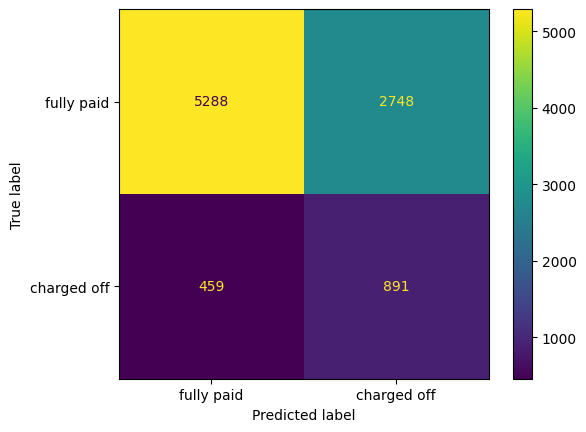

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, lr_val_preds, labels=lr_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fully paid', 'charged off'])
disp.plot();

## SVM ##

In [ ]:
svm = SVC()
svm.fit(X_train_transformed_df, y_train)

SVC()

In [ ]:
y_pred = svm.predict(X_test_transformed_df)

In [ ]:
# 1. Instantiate the SVM
svm = SVC(random_state=42, class_weight='balanced', max_iter=100000)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'kernel': ['linear'],
             'C': [0.5, 1, 10]             
            }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'roc_auc', 'recall', 'f1', 'precision']

# 4. Instantiate the GridSearchCV object
svm_cv = GridSearchCV(svm, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
svm_cv.fit(X_train_transformed_df, y_train)

GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', max_iter=100000,
                           random_state=42),
             param_grid={'C': [0.5, 1, 10], 'kernel': ['linear']},
             refit='recall',
             scoring=['accuracy', 'roc_auc', 'recall', 'f1', 'precision'])

In [ ]:
svm_cv.best_score_

0.6206507042683391

In [ ]:
svm_cv.best_params_

{'C': 0.5, 'kernel': 'linear'}

In [ ]:
svm_cv_results = make_results('SVM CV', svm_cv, 'roc_auc')
results = pd.concat([results, svm_cv_results], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847
0,SVM CV,0.702313,0.620651,0.342375,0.657149,0.236427


In [ ]:
svm_test_preds = svm_cv.best_estimator_.predict(X_test_transformed_df)

In [ ]:
svm_test_scores = get_test_scores('SVM val', svm_test_preds, y_test)

results = pd.concat([results, svm_test_scores], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847
0,SVM CV,0.702313,0.620651,0.342375,0.657149,0.236427
0,SVM val,0.659598,0.686667,0.354493,0.640315,0.238918


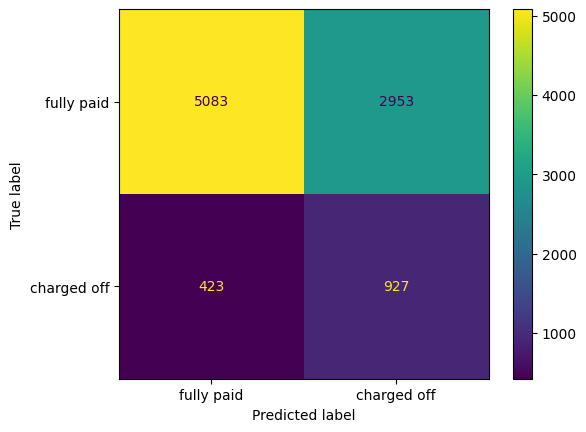

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, svm_test_preds, labels=svm_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fully paid', 'charged off'])
disp.plot();

## Random Forest ##

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_transformed_df, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test_transformed_df)

In [ ]:
# 1. Instantiate Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [2, 3, None],
             'max_features': [1.0, 2.0],
             'max_samples': [0.7],
              'min_samples_leaf': [5],
              'min_samples_split': [2],
              'n_estimators': [300]
              }  


# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'roc_auc', 'recall', 'f1', 'precision']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
rf_cv.fit(X_train_transformed_df, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [2, 3, None], 'max_features': [1.0, 2.0],
                         'max_samples': [0.7], 'min_samples_leaf': [5],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall',
             scoring=['accuracy', 'roc_auc', 'recall', 'f1', 'precision'])

In [ ]:
rf_cv.best_score_

0.7436429672358802

In [ ]:
rf_cv.best_params_

{'max_depth': 2,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
rf_cv_results = make_results('Random Forest CV', rf_cv, 'roc_auc')
results = pd.concat([results, rf_cv_results], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847
0,SVM CV,0.702313,0.620651,0.342375,0.657149,0.236427
0,SVM val,0.659598,0.686667,0.354493,0.640315,0.238918
0,Random Forest CV,0.690614,0.140775,0.202488,0.840578,0.361139


In [ ]:
rf_test_preds = rf_cv.best_estimator_.predict(X_test_transformed_df)

In [ ]:
rf_test_scores = get_test_scores('Random Forest val', rf_test_preds, y_test)

results = pd.concat([results, rf_test_scores], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847
0,SVM CV,0.702313,0.620651,0.342375,0.657149,0.236427
0,SVM val,0.659598,0.686667,0.354493,0.640315,0.238918
0,Random Forest CV,0.690614,0.140775,0.202488,0.840578,0.361139
0,Random Forest val,0.627227,0.768889,0.318307,0.526316,0.200696


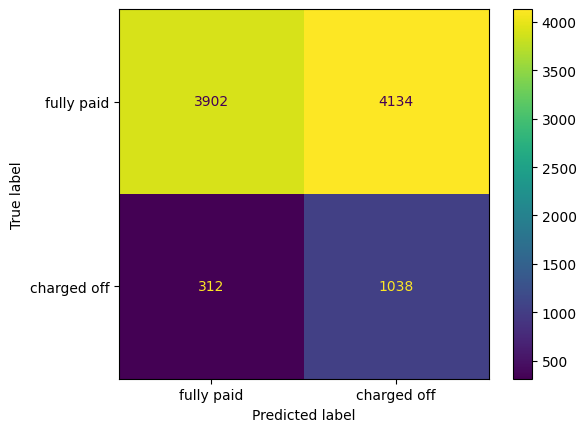

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_test_preds, labels=rf_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fully paid', 'charged off'])
disp.plot();

## XG BOOST ##

In [ ]:
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(X_train_transformed_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb.predict(X_test_transformed_df)

In [ ]:
# 1. Instantiate XGBoost
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             } 


# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'roc_auc', 'recall', 'f1', 'precision']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
xgb_cv.fit(X_train_transformed_df, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall',
             scoring=['accuracy', 'roc_auc', 'recall', 'f1', 'precision'])

In [ ]:
xgb_cv.best_score_

0.06816462940072335

In [ ]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [ ]:
xgb_cv_results = make_results('XGBoost CV', xgb_cv, 'roc_auc')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847
0,SVM CV,0.702313,0.620651,0.342375,0.657149,0.236427
0,SVM val,0.659598,0.686667,0.354493,0.640315,0.238918
0,Random Forest CV,0.690614,0.140775,0.202488,0.840578,0.361139
0,Random Forest val,0.627227,0.768889,0.318307,0.526316,0.200696
0,XGBoost CV,0.701191,0.009632,0.018893,0.856169,0.517351


In [ ]:
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test_transformed_df)

In [ ]:
xgb_test_scores = get_test_scores('XGBoost val', xgb_test_preds, y_test)

results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847
0,SVM CV,0.702313,0.620651,0.342375,0.657149,0.236427
0,SVM val,0.659598,0.686667,0.354493,0.640315,0.238918
0,Random Forest CV,0.690614,0.140775,0.202488,0.840578,0.361139
0,Random Forest val,0.627227,0.768889,0.318307,0.526316,0.200696
0,XGBoost CV,0.701191,0.009632,0.018893,0.856169,0.517351
0,XGBoost val,0.521891,0.065185,0.109317,0.847219,0.338462


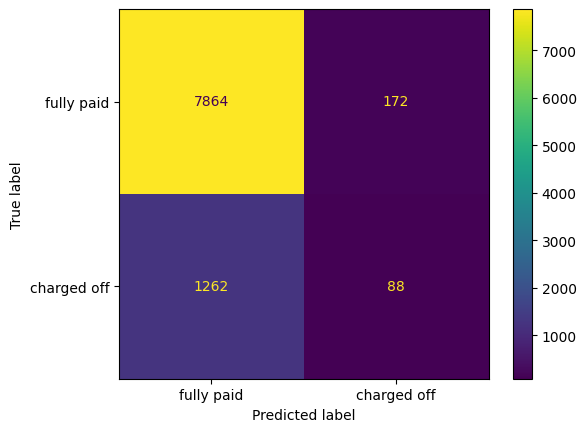

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fully paid', 'charged off'])
disp.plot();

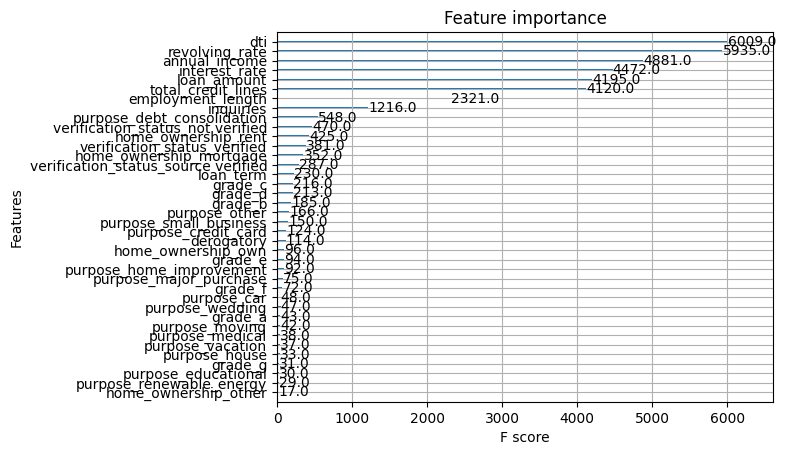

In [ ]:
plot_importance(xgb_cv.best_estimator_);

## Ada Boost ##

In [ ]:
adb = AdaBoostClassifier()
adb.fit(X_train_transformed_df, y_train)

AdaBoostClassifier()

In [ ]:
y_pred = adb.predict(X_test_transformed_df)

In [ ]:
# 1. Instantiate Adaboost
adb = AdaBoostClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {
             'learning_rate': [0.01, 0.1, 0.5],
             'n_estimators': [100, 300]
             } 


# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'roc_auc', 'recall', 'f1', 'precision']

# 4. Instantiate the GridSearchCV object
adb_cv = GridSearchCV(adb, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
adb_cv.fit(X_train_transformed_df, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [100, 300]},
             refit='recall',
             scoring=['accuracy', 'roc_auc', 'recall', 'f1', 'precision'])

In [ ]:
adb_cv.best_score_

0.027415648033695006

In [ ]:
adb_cv.best_params_

{'learning_rate': 0.5, 'n_estimators': 300}

In [ ]:
adb_cv_results = make_results('AdaBoost CV', adb_cv, 'roc_auc')
results = pd.concat([results, adb_cv_results], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847
0,SVM CV,0.702313,0.620651,0.342375,0.657149,0.236427
0,SVM val,0.659598,0.686667,0.354493,0.640315,0.238918
0,Random Forest CV,0.690614,0.140775,0.202488,0.840578,0.361139
0,Random Forest val,0.627227,0.768889,0.318307,0.526316,0.200696
0,XGBoost CV,0.701191,0.009632,0.018893,0.856169,0.517351
0,XGBoost val,0.521891,0.065185,0.109317,0.847219,0.338462
0,AdaBoost CV,0.703703,0.019513,0.037525,0.856133,0.491838


In [ ]:
adb_test_preds = adb_cv.best_estimator_.predict(X_test_transformed_df)

In [ ]:
adb_test_scores = get_test_scores('AdaBoost val', adb_test_preds, y_test)

results = pd.concat([results, adb_test_scores], axis=0)
results

,model,roc_auc,recall,F1,accuracy,precision
0,Logistic Regression CV,0.705540,0.641644,0.346313,0.651715,0.237180
0,LogisticRegression val,0.659019,0.660000,0.357186,0.658321,0.244847
0,SVM CV,0.702313,0.620651,0.342375,0.657149,0.236427
0,SVM val,0.659598,0.686667,0.354493,0.640315,0.238918
0,Random Forest CV,0.690614,0.140775,0.202488,0.840578,0.361139
0,Random Forest val,0.627227,0.768889,0.318307,0.526316,0.200696
0,XGBoost CV,0.701191,0.009632,0.018893,0.856169,0.517351
0,XGBoost val,0.521891,0.065185,0.109317,0.847219,0.338462
0,AdaBoost CV,0.703703,0.019513,0.037525,0.856133,0.491838
0,AdaBoost val,0.507452,0.019259,0.036853,0.855210,0.426230


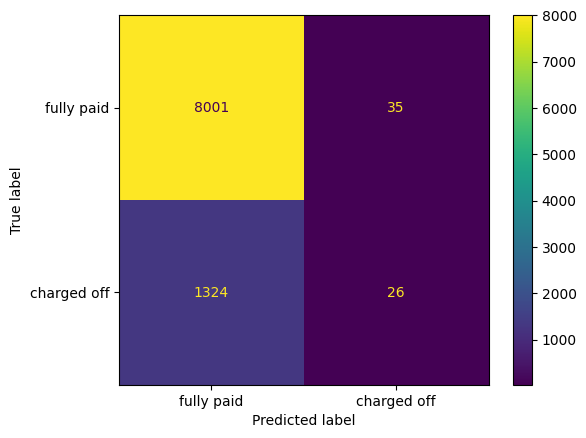

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, adb_test_preds, labels=adb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fully paid', 'charged off'])
disp.plot();

# PICKLE #

In [ ]:
import pickle 

# Define a path to the folder where you want to save the model
path = '../model/'

In [ ]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [ ]:
write_pickle(path, lr_cv, 'lr')

                    model   roc_auc    recall        F1  accuracy  precision
0  Logistic Regression CV  0.705540  0.641644  0.346313  0.651715   0.237180
0  LogisticRegression val  0.659019  0.660000  0.357186  0.658321   0.244847


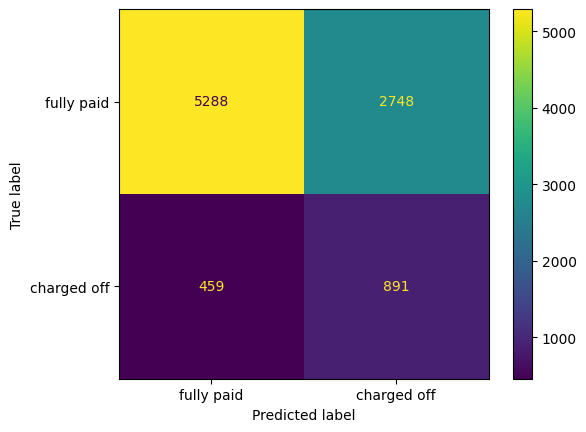

In [ ]:
%run ../train.py

## APLICACION MODELO PRESTAMOS VIGENTES ##

Aunque las métricas del mejor modelo, que el el Logistic Regression son poco mejores que mediocres, vamos a aplicar el modelo a los préstamos vigentes, sabiendo que solo 
servirá para predecir la probabilidad de impago de 2 de cada 3 préstamos.

Una posible solución para mejorar estas métricas pueden ser:

- Obtener más datos y mejores
- Aplicar más modelos y ver si pueden mejorar estos datos
- Aplicar mejores hiperparámetros

In [ ]:
from train import cargar_dataset, eliminar_columnas, rellenar_nans_con_cero, escala_logaritmica, igualar_valores_extremos_iqr, pipeline_preprocess_data

In [ ]:
df = pd.read_csv('../data/processed/df_final_current.csv')

In [ ]:
df.head(10)

,id,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,1075358,3000,60,12.69,b,source verified,other,17.94,0,0,53.9,38,1.0,rent,11.289782
1,1065420,10000,60,15.96,c,verified,debt_consolidation,22.83,1,0,63.6,31,2.0,rent,10.279181
2,1069346,12500,60,12.69,b,verified,debt_consolidation,16.04,3,0,50.0,24,1.0,rent,10.203592
3,1063958,14000,60,17.27,d,verified,other,6.34,2,0,79.4,10,4.0,rent,10.239960
4,1068575,15300,60,22.06,f,verified,credit_card,20.58,2,0,89.7,27,6.0,rent,11.350407
5,1067874,6000,60,12.69,b,source verified,major_purchase,13.66,0,0,50.0,17,1.0,rent,11.302204
6,1034693,16000,60,17.58,d,not verified,debt_consolidation,15.56,0,0,87.1,16,7.0,rent,11.082143
7,1046969,11000,60,13.49,c,verified,debt_consolidation,10.94,0,0,24.1,31,10.0,mortgage,11.767568
8,1066664,21000,60,17.27,d,verified,debt_consolidation,7.75,0,0,50.3,16,10.0,mortgage,11.599103
9,1066659,16000,60,17.27,d,source verified,debt_consolidation,11.04,0,0,42.2,16,2.0,rent,10.819778


In [ ]:
eliminar_columnas(df, ['id'])

In [ ]:
df.isna().sum()

loan_amount            0
loan_term              0
interest_rate          0
grade                  0
verification_status    0
purpose                0
dti                    0
inquiries              0
derogatory             0
revolving_rate         0
total_credit_lines     0
employment_length      0
home_ownership         0
annual_income          0
dtype: int64

In [ ]:
igualar_valores_extremos_iqr(df, 'annual_income', 4)

,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,3000,60,12.69,b,source verified,other,17.94,0,0,53.9,38,1.0,rent,11.289782
1,10000,60,15.96,c,verified,debt_consolidation,22.83,1,0,63.6,31,2.0,rent,10.279181
2,12500,60,12.69,b,verified,debt_consolidation,16.04,3,0,50.0,24,1.0,rent,10.203592
3,14000,60,17.27,d,verified,other,6.34,2,0,79.4,10,4.0,rent,10.239960
4,15300,60,22.06,f,verified,credit_card,20.58,2,0,89.7,27,6.0,rent,11.350407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,10400,60,6.00,e,source verified,credit_card,10.84,0,0,95.6,15,5.0,mortgage,10.275051
1094,6000,60,10.37,b,source verified,car,11.05,0,0,0.2,9,1.0,rent,10.085809
1095,19200,60,10.74,b,verified,small_business,4.43,0,0,0.0,10,5.0,mortgage,11.512925
1096,9350,60,10.00,b,not verified,car,4.84,0,0,5.9,7,8.0,rent,11.097410


In [ ]:
# Definir las columnas categóricas y numéricas
categorical_cols = ['grade', 'verification_status', 'purpose', 'home_ownership']
numeric_cols = ['loan_amount', 'loan_term', 'interest_rate', 'dti', 'inquiries',
                'derogatory', 'revolving_rate', 'total_credit_lines', 'employment_length', 'annual_income']

In [ ]:
df = pipeline_preprocess_data(df, numeric_cols=numeric_cols, categorical_cols=categorical_cols)

In [ ]:
df.shape

(1098, 36)

In [ ]:
# APLICAMOS EL MODELO DE REGRESION LOGISTICA PARA OBTENER LOS VALORES PREVISTOS


y_pred_current = lr.best


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.